In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import graphviz
from sklearn.tree import export_graphviz
from imageio import imread

import plotly.graph_objects as go # colab
# from plotly import graph_objs as go # local, old version plotly

cm2 = ListedColormap(['C1', 'C2'])
cm3 = ListedColormap(['C1', 'C2', 'C3'])
cm8 = ListedColormap(['#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', 
                      '#ff7c43', '#ffa600'])
image_dpi=150

# 그래디언트 부스트Gradient Boost

## 들어가며

부스팅 알고리즘은 약한 학습기weak learner를 순차적으로 학습시키고 개별 학습기의 예측을 모두 더해 최종 예측을 만들어내는 앙상블 메소드의 한 종류입니다. 그 중 그래디언트 부스팅은 강력한 성능으로 가장 많이 애용되는 알고리즘입니다. 

인기가 많은 알고리즘이다 보니 많은 머신러닝 교재에서도 꼭 등장하는 편입니다. 주로 이전 단계 학습기가 만들어낸 잔차residual을 타겟으로  개별 학습기를 순차적으로 학습하는 방법을 보여주면서 직관적으로 알고리즘을 설명합니다. 하지만 이런 방식으로는 왜 '그래디언트'라는 단어가 등장하는지 잘 설명되지 않습니다. 그리고 어떻게 어떻게 설명한다 하더라도 주로 회귀문제에 국한하여 설명하는 것이 대부분입니다. 이렇게 많은 설명이 피상적인 수준에 머무르는 이유는 이 알고리즘을 제대로 설명하기 위해서 좀 복잡한 최적화 방법을 이야기해야하기 때문입니다. 

하지만 결론적으로 이야기하면 회귀문제를 중심으로 간단하게 그래디언트 부스팅을 이해하면 실용적으로 알고리즘을 활용하기에 충분하다 할 수 있습니다. 왜냐하면 분류문제가 된다하더라도 회귀문제의 논리가 동일하게 적용되기 때문입니다. 실제로 회귀에 사용되는 오차제곱합 손실을 사용하는 방식을 그대로 분류 문제에 적용해도 잘 작동합니다. 굳이 분류문제를 예로 들지 않아도 크게 달라지는건 없습니다. 이런 이유로 우선 회귀문제를 중심으로 최대한 간단하게 그래디언트 부스팅을 이해한 다음 분류문제에 대한 구체적인 이야기를 이어가도록 하겠습니다.

회귀문제를 설명하는 좋은 예제는 다음과 같습니다.<sup>1</sup>


--- 
1. 아래 예제는 핸즈온 머신러닝에 나온 예를 참고하였습니다.

## 간단한 회귀문제 예

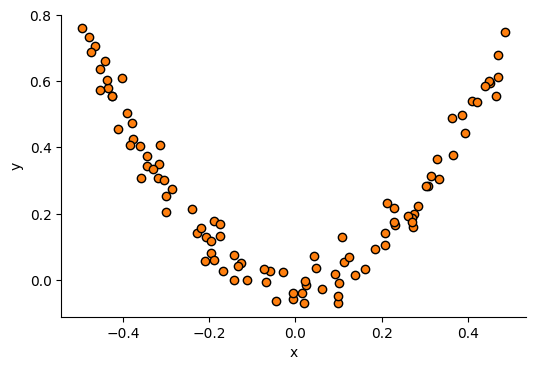

In [ ]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
X_reg = np.random.rand(100, 1) - 0.5
y_reg = 3*X_reg[:,0]**2 + 0.05 * np.random.randn(100)

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

# fig.savefig("first_step1.png", dpi=image_dpi, bbox_inches='tight')

위와 같은 데이터에 결정회귀트리를 적합시키겠습니다. 처음에는 타겟의 평균만 출력하는 더미 학습기로 출발합니다.

In [ ]:
# 개별학습기 로드
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

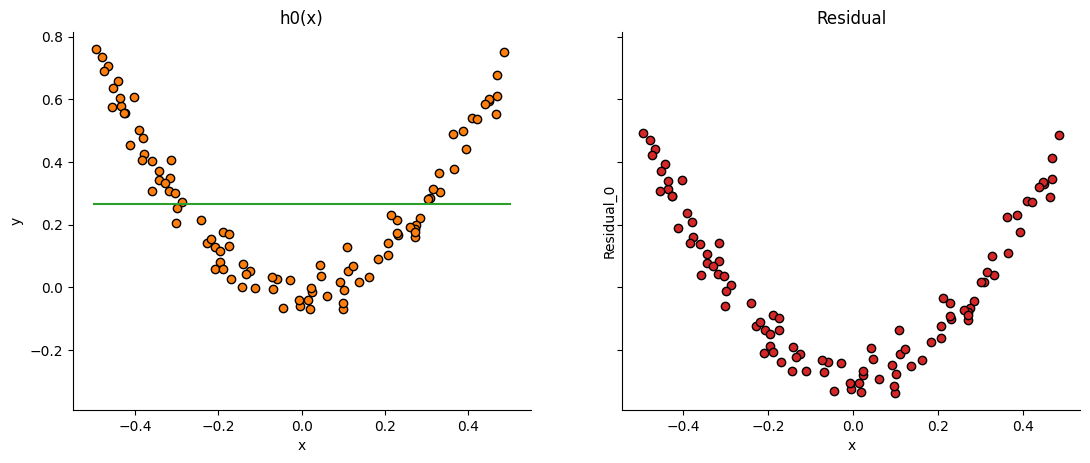

In [ ]:
# 아주 약한 0번째 학습기를 한번 학습시킨다.
h0 = DummyRegressor(strategy="mean").fit(X_reg, y_reg)

# 예측하고 잔차를 구한다.
y_h0 = h0.predict(X_reg)
r0 = y_reg - y_h0

# 결과를 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000).reshape(-1,1)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True, dpi=100)

ax[0].scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k')
ax[0].plot(x, h0.predict(x.reshape(-1,1)), color='C2')
ax[0].set_title('h0(x)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

ax[1].scatter(X_reg, r0, marker='o', color='C3', edgecolor='k')
ax[1].set_title('Residual')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Residual_0')
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)

plt.show()

# fig.savefig("first_step_h0.png", dpi=image_dpi, bbox_inches='tight')

위 그래프에서 왼쪽 그림은 주어진 데이터와 초기 더미 학습기 $h_0(x)$의 출력을 나타내고 오른쪽 그림은 더미 학습기가 만든 출력으로부터 잔차residual을 계산하여 그린 것입니다. 두번째 학습기는 첫번째 학습기가 만든 이 오차를 타겟으로 학습하게 됩니다. 계속 이런식으로 반복합니다.

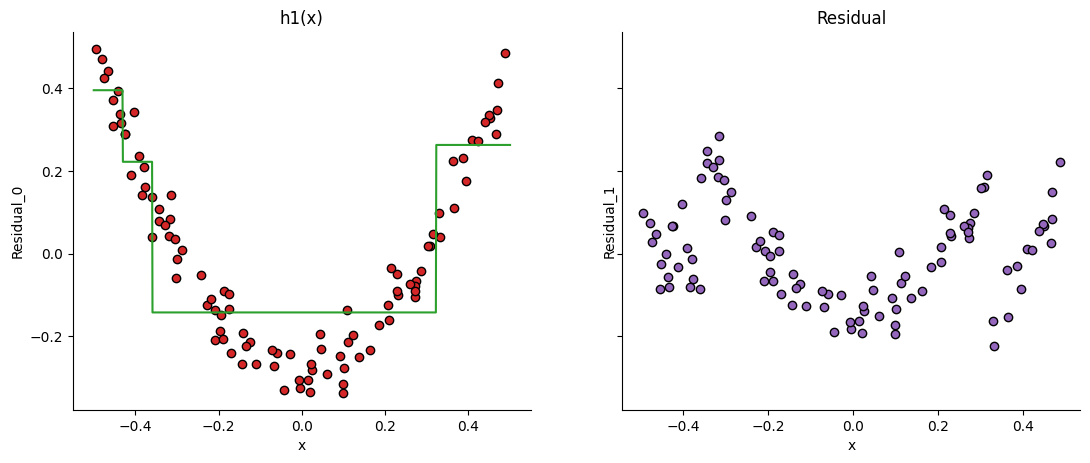

In [ ]:
# 아주 약한 1번째 학습기를 한번 학습시킨다.
# X_reg에 대한 타겟을 이번에는 r0로 설정해서 학습한다.
# 또 개별 학습기는 max_depth=2로 설정하여 그리 깊지 않은 트리가 생성되게 한다.
h1 = DecisionTreeRegressor(max_depth=2).fit(X_reg, r0)

# 예측하고 잔차를 구한다.
y_h1 = h1.predict(X_reg)
r1 = r0 - y_h1

# 결과를 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000).reshape(-1,1)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True, dpi=100)

ax[0].scatter(X_reg, r0 , marker='o', color='C3', edgecolor='k')
ax[0].plot(x, h1.predict(x.reshape(-1,1)), color='C2')
ax[0].set_title('h1(x)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Residual_0')
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

ax[1].scatter(X_reg, r1, marker='o', color='C4', edgecolor='k')
ax[1].set_title('Residual')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Residual_1')
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)

plt.show()

# fig.savefig("first_step_h1.png", dpi=image_dpi, bbox_inches='tight')

위 그림에서 왼쪽 그림은 데이터로 이전 그림의 오른쪽에 그려진 잔차를 그리고 이에 대한 $h_1(x)$의 출력을 나타낸 것입니다. 오른쪽은 이렇게 $h_1(x)$의 출력으로 부터 다시 에러를 계산하여 그린 것입니다. 한번 더 반복하겠습니다.

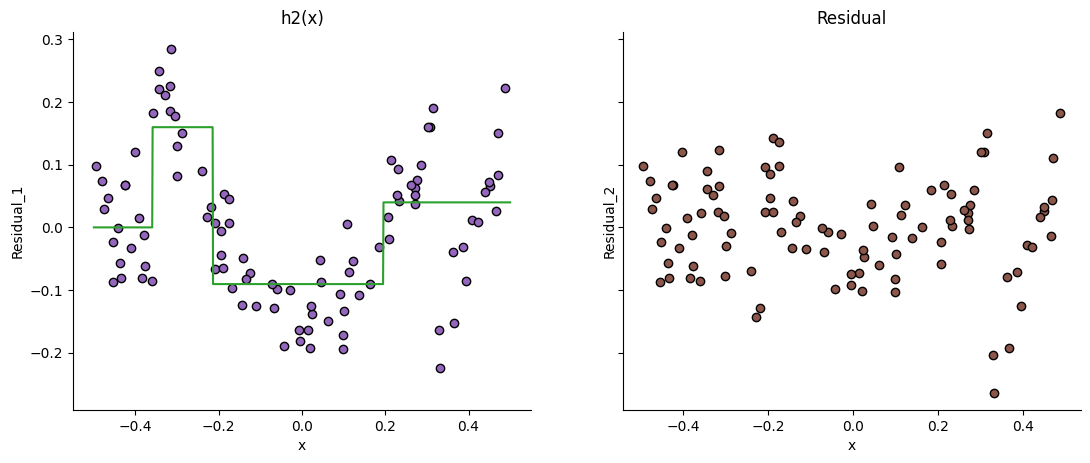

In [ ]:
# 아주 약한 2번째 학습기를 한번 학습시킨다.
h2 = DecisionTreeRegressor(max_depth=2).fit(X_reg, r1)

# 예측하고 잔차를 구한다.
y_h2 = h2.predict(X_reg)
r2 = r1 - y_h2

# 결과를 그림으로 확인
x = np.linspace(-0.5, 0.5, 1000).reshape(-1,1)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True, dpi=100)

ax[0].scatter(X_reg, r1 , marker='o', color='C4', edgecolor='k')
ax[0].plot(x, h2.predict(x), color='C2')
ax[0].set_title('h2(x)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Residual_1')
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

ax[1].scatter(X_reg, r2, marker='o', color='C5', edgecolor='k')
ax[1].set_title('Residual')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Residual_2')
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)

plt.show()

# fig.savefig("first_step_h2.png", dpi=image_dpi, bbox_inches='tight')

이제 세 학습기에 $[-0.5,0.5]$를 입력하여 출력을 구해서 모두 더해 최종 출력을 만들어 냅니다. 이렇게 약한 학습기 세 개를 더한 최종 예측이 얼마나 잘 맞는지 확인해보겠습니다.

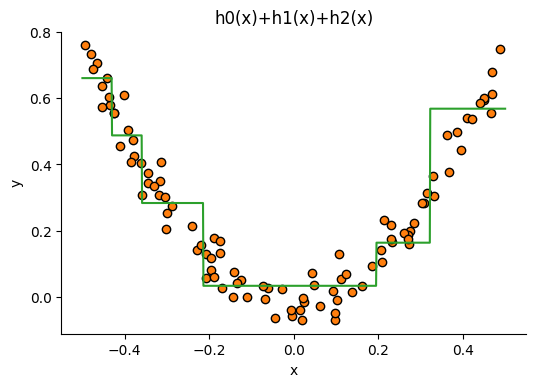

In [ ]:
# 학습기 0번, 1번, 2번을 다 더한다.
pred = ( h0.predict(x) + h1.predict(x) + h2.predict(x) )

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k')
ax.plot(x, pred, color='C2')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("h0(x)+h1(x)+h2(x)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

# fig.savefig("first_step_h0h1h2.png", dpi=image_dpi, bbox_inches='tight')

데이터의 전체 구조를 잘 따라가는 것을 확인할 수 있습니다.

이런 방식은 0번 학습기가 틀린만큼 1번 학습기가 예측하여 더해주고 1번 학습기 조차 틀린 부분을 2번 학습기가 보완해주는 방식으로 진행합니다. 이런 방식으로 결과가 좋아진다는 것을 직관적으로 이해할 수 있는데 여기까지 설명으로는 그래디언트가 어느 장면에서 등장하는지 알 수 없습니다.

많은 공개 강의나 블로그 글에서 이 후 그래디언트가 등장하는 장면을 간략하게 설명하는데 이 글에서는 조금 더 자세하게 이야기 해보도록 하겠습니다.

참고로 앞으로 나오는 식번호에 (1) 모양으로 붙은 식번호는 그래디언트 부스팅 원논문의 식번호를 그대로 쓴 것이며 이 글에서 사용하는 식번호는 ([1])식으로 붙였습니다.

## 매개변수 서치

벡터 변수 $\mathbf{x}$와 그에 대응되는 타겟값  $y$가 있을 때 지도학습의 목표는 입력 $\mathbf{x}$를 적절히 출력 $y$로 매핑하는 함수 $F(\mathbf{x})$를 찾는 것입니다. 그렇게 찾아진 최적의 함수를 $F^{*}(\mathbf{x})$라하면 이는 개념적으로 다음처럼 쓸 수 있습니다.
 

$$
F^{*} = \underset{F}{\text{argmin}} \, \mathbb{E}_{y,\mathbf{x}} \left[ L(y, F(\mathbf{x}) \right] \tag{1}
$$

위 식에서 $L$은 $y$와 $F$의 차이를 설명하는 적절한 손실함수loss function입니다. 그러면 식(1)은 이 함수가 정의된 변수들의 존재하는 모든 경우에 대해 평균을 낸 것이 되고 이를 최소화하는 $F(\mathbf{x})$를 찾는 것이 됩니다.

보통의 경우 $F(\mathbf{x})$를 특정한 형태의 함수로 제한하고 그 제한된 범위에서 함수를 결정하는 매개변수parmeter $\mathbf{P}$를 찾게 됩니다. 다시말해 $F(\mathbf{x};\mathbf{P})$에서 $\mathbf{P}$를 결정하는 문제를 다루게 됩니다. 예를들어 $F(\mathbf{x};\mathbf{P})$가 $p$차 다항식이라면 매개변수는 $p+1$개의 개수가 될것입니다. 또는 $F(\mathbf{x};\mathbf{P})$가 인공신경망이라면 신경망의 형태(네트워크 구조)를 고정하고 신경망의 매개변수를 결정하는 것이 될 것입니다.

그래디언트 부스팅에서는 함수 $F(\mathbf{x};\mathbf{P})$를 다음처럼 매개변수 $\mathbf{a}$에 의해 결정되는 $M$개의 일반적인 함수 $h$의 합으로 이뤄지는 함수라고 설정합니다.

$$
F\left(\mathbf{x}; \{\beta_m, \mathbf{a}_m\}^M_{m=1}\right) = \sum_{m=1}^M \beta_m h (\mathbf{x}; \mathbf{a}_m)
$$

이렇게 정의된 문제에서 매개변수 공간을 서치하기 위해 일반적인 최적화 과정을 도입할 수 있습니다. 함수 $F(\mathbf{x})$를 고정하고 매개변수를 최적화 할 것이기 때문에 매개 변수에 대한 손실함수를 다음처럼 적으면

$$
\Phi(\mathbf{P}) = \mathbb{E}_{y, \mathbf{x}} \left[ L(y, F(\mathbf{x}; \mathbf{P}) \right]
$$

최적의 매개변수는 다음처럼 찾아야 하고

$$
\mathbf{P}^* = \underset{\mathbf{P}}{\text{argmin}} \, \Phi (\mathbf{P}) \tag{3}
$$

이렇게 결정된 $\mathbf{P}^*$를 이용해 다음처럼 $F^* (\mathbf{x})$를 구할 수 있습니다.

$$
F^{*} (\mathbf{x}) = F(\mathbf{x}; \mathbf{P}^{*} )
$$

위 식에서 $\mathbf{P}^{*}$를 결정하기 위해 식(3)을 최적화 과정을 통해 풀어야 하는데 $M+1$번 단계를 거쳐 결정된 $\mathbf{P}^{*}$를 다음처럼 쓸 수 있습니다.

$$
\mathbf{P}^{*} = \sum_{m=0}^{M} \mathbf{p}_m \tag{4}
$$

식(4)에서 $\mathbf{p}_m$은 각 최적화 단계에서 결정되는 업데이트 벡터입니다. 그래서 $\mathbf{p}_m$은 최적화 수법에 따라 정의될텐데 여기서는 가장 간단한 최속강하법steepest descent method를 고려합니다.

### 최속강하법

최속강하법은 최적화 알고리즘에가 가장 간단한 형태이나 최근 딥러닝에서 많이 사용하는 확률적 경사하강법과 거의 동일한 알고리즘입니다. 방법의 핵심은 주어진 목적함수(손실함수)를 설계변수(여기서는 매개변수)로 미분한 그래디언트의 반대방향으로 설계변수를 업데이트하는 것입니다.

앞선 절에서 정의한 손실함수 $\Phi(\mathbf{P})$에 대한 매개변수 $\mathbf{P}$에 대한 단계 $m$에서 그래디언트는 다음과 같습니다.

$$
\mathbf{g}_m = \{g_{jm}\} =\left\{ \left[  \frac{\partial \, \Phi(\mathbf{P})}{\partial P_j} \right]_{\mathbf{P}=\mathbf{P}_{m-1}} \right\}
$$

위 식은 매개변수 공간에서 $\mathbf{P}_{m-1}$의 위치에서 그래디언트를 나타냅니다. 그래디언트가 구체적인 벡터로 정의되려면 편도함수들에 현재 그래디언트가 정의되는 위치를 대입해야 한다는 사실을 상기합시다. 이를 나타내는 표현이 대괄호 아랫쪽에 $\mathbf{P}=\mathbf{P}_{m-1}$입니다. 그리고 $\mathbf{P}_{m-1}$은 단계 $m-1$까지 $\mathbf{p}_m$들이 누적된 벡터입니다.

$$
\mathbf{P}_{m-1} = \sum_{i=0}^{m-1} \mathbf{p}_i
$$

각 단계에서 $\mathbf{p}_m$은 다음처럼 그래디언트 $\mathbf{g}_m$의 반대방향으로 $\rho_m$만큼 이동한 벡터입니다. 

$$
\mathbf{p}_m = -\rho_m \mathbf{g}_m
$$


$\rho_m$은 선탐색line search라는 과정으로 구할 수 있으며 다음과 같습니다.

$$
\rho_m = \underset{\rho}{\text{argmin}}\, \Phi(\mathbf{P}_{m-1} - \rho \, \mathbf{g}_m) \tag{5}
$$

이상의 내용은 조금 추상적으로 느껴질 수 있지만 기호가 좀 복잡할 뿐 보통 매개변수를 최적화하는 일반적인 내용에 지나지 않습니다. 그래디언트 부스팅이 복잡하게 느껴지는 이유는 이 같은 매개변수 최적화와 달리 함수공간에서 함수를 탐색하고자 하기 때문입니다.

## 함수 서치

입력변수 $\mathbf{x}$와 출력변수 $y$의 결합확률분포 상에서 손실함수 $L(y, F(\mathbf{x}))$의 기대값은 $\mathbb{E}_{y, \mathbf{x}}\left[ L(y, F(\mathbf{x}))\right]$이며 이를 최소화하는 '매개변수'로써의 함수 $F(\mathbf{x})$를 생각해볼 수 있습니다. 이를 좀 더 명시적으로 표시하기 위해 다음처럼 $F$를 변수로 하는 범함수functional로 쓰기로 합시다.

$$
\Phi(F) = \mathbb{E}_{y, \mathbf{x}}\left[ L(y, F(\mathbf{x}))\right]
$$

기댓값의 정의에 의해

$$
\begin{aligned}
\Phi(F) &= \int_{\mathbf{x}} \int_{y} L(y, F(\mathbf{x})) f_{XY}(\mathbf{x}, y) \, dy \, d\mathbf{x} \\[5pt]
&= \int_{\mathbf{x}} \int_{y} L(y, F(\mathbf{x})) f_{Y \mid X}(y \mid \mathbf{x}) \, dy \, f_X (\mathbf{x}) \, d \mathbf{x} \\[5pt]
&= \mathbb{E}_{\mathbf{x}} \left[ \,\mathbb{E}_{y} [\,L(y,F(\mathbf{x}))\mid \mathbf{x}\,] \, \right]
\end{aligned}
$$

로 쓰고 위 식에서

$$
\phi(F(\mathbf{x}))= \mathbb{E}_{y} [\,L(y,F(\mathbf{x}))\mid \mathbf{x}\,] 
$$

로 두면 $\phi(F(\mathbf{x}))$는 주어진 $\mathbf{x}$에 대해서 함수 $F$를 바꿔치기 하면 함수 값이 달라지는 함수가 됩니다. $\phi(F(\mathbf{x}))$를 최소화하는 무수히 많은 후보 함수 $F$에서 최적의 함수를 찾기 위해 앞서 이야기한 최속강하법을 함수 공간에 적용하는 것을 생각해봅시다.

식(4)에서 각 최적화 단계에서 구한 매개변수 벡터 $\mathbf{p}_m$을 모두 더해 최적의 매개변수 벡터를 업데이트 했습니다. 이렇게 최적화 단계는 보통 유한한 길이를 가지는 벡터변수에 대해 그래디언트를 구하고 그것에 마이너스를 곱해 최적화 하고자 하는 변수를 업데이트 합니다. 하지만 지금은 $\phi(F(\mathbf{x}))$를 최소화하는 변수가 함수입니다. 따라서 최적화되는 변수는 요소 개수가 무한대인 벡터 변수라고 생각할 수 있습니다. 즉 함수 자체가 "매개변수"인 것입니다. 그러면 각 최적화 단계에서 찾아지는 벡터는 그 자체로 함수가 되며 그 함수들을 $f_m(\mathbf{x})$라 하면 이를 모두 더한 

$$
F^* (\mathbf{x}) = \sum_{m=0}^M f_m (\mathbf{x})
$$

가 최적해가 되며 여기서 매 최적화 단계에서 $f_m(\mathbf{x})$는

$$
f_m(\mathbf{x}) = - \rho_m g_m(\mathbf{x}) \tag{6}
$$

입니다. 식(6)은 최속강하법 매단계에서 구해지는 마이너스 그래디언트가 $\mathbf{x}$의 함수인 $g_m(\mathbf{x})$임을 의미합니다.


$m$번째 단계에서 그래디언트 $g_m(\mathbf{x})$은 $F(\mathbf{x})$를 매개변수로 보고 다음처럼 구할 수 있습니다.

$$
g_m(\mathbf{x}) = \left[ \frac{\partial \, \phi(F(\mathbf{x}))}{\partial \, F(\mathbf{x})} \right]_{F(\mathbf{x}) = F_{m-1}({\mathbf{x}})} = \left[ \frac{\partial \, \mathbb{E}_{y} [\,L(y,F(\mathbf{x}))\mid \mathbf{x}\,]   }{\partial F(\mathbf{x})} \right]_{F(\mathbf{x}) = F_{m-1}({\mathbf{x}})}
$$

여기서 $F_{m-1}(\mathbf{x})$은 다음처럼 개별 단계에서 찾아진 $f_i(\mathbf{x})$를 0단계부터 $m-1$단계까지 더한

$$
F_{m-1}(\mathbf{x}) = \sum_{i=0}^{m-1} f_i(\mathbf{x})
$$

입니다. 위 $g_m(\mathbf{x})$을 구하는 과정을 보면 $F$로 미분하고 구체적인 그래디언트를 구하기 위해 $F(\mathbf{x}) = F_{m-1}({\mathbf{x}})$처럼 이전 단계에서 구해진 함수를 대입하는 것을 확인할 수 있습니다. 즉 그래디언트를 구하는 위치가 $F_{m-1}(\mathbf{x})$인 것입니다. 그리고 적분과 미분의 순서를 바꾸면

$$
g_m(\mathbf{x}) = \mathbb{E}_{y} \left[ \frac{\partial \, L(y,F(\mathbf{x})) }{\partial F(\mathbf{x})} \mid \mathbf{x} \right]_{F(\mathbf{x}) = F_{m-1}({\mathbf{x}})} \tag{7}
$$

손실함수를 함수 형태인 매개변수로 편미분하고 주어진 $\mathbf{x}$에 어떤 $y$가 매치 될지 모르니 $f_{Y \mid X}(y \mid \mathbf{x})$상에서 $y$에 대해서 평균을 규해서 최종적인 함수를 구해내게 됩니다. 이 함수가 바로 매개변수 $F(\mathbf{x})$에 대한 그래디언트가 됩니다. 그래디언트를 구했으므로 식(6)에 있는 그래디언트 $g_m(\mathbf{x})$ 방향으로 손실함수의 기댓값을 최소화하는 스탭사이즈 $\rho_m$을 찾게 됩니다.

$$
\rho_m = \underset{\rho}{\text{argmin}} \, \mathbb{E}_{y, \mathbf{x}}\left[ L(\, y, F_{m-1}(\mathbf{x}) - \rho \, g_m(\mathbf{x})\, )\right] \tag{8}
$$

### 유한개 데이터에 대해

지금까지 이야기한 함수를 바로 찾는 방법은 유한개의 데이터 $N$개만 가진 현실적인 경우에 적용할 수 없습니다. $L(y, F)$을 $F$로 미분해서 $y$에 대해 적분해야지 함수로써의 그래디언트가 구해지게 되는데 이 적분을 수행할 수 가 없습니다. $f_{XY}$와 $f_{Y \mid X}$를 모르고 그냥 $f_{XY}$에서 샘플링된 데이터 $N$개만 가지고 있으니 그래디언트를 함수 형태로 구할 수 없습니다.

때문에 다음처럼 주어진 데이터 포인트에 대해서 그래디언트 함수의 함수값 $N$개만 구할 수 있습니다. 

데이터 $\mathcal{D}=\{\mathbf{x}_i, y_i\}_{i=1}^N$가 주어져 있을 때 식(7)로 주어지는 그래디언트의 마이너스곱한 값을 $\mathbf{x}_i$, $y_i$에 대해서 근사해보면 

$$
-g_m (\mathbf{x}_i) = - \left[ \frac{\partial \, L(y_i, F(\mathbf{x}_i)) }{\partial F(\mathbf{x}_i)} \right]_{F(\mathbf{x}) = F_{m-1}({\mathbf{x}})}
$$

로 구할 수 있습니다. 이렇게 모두 $-g_m(\mathbf{x}_i)$를 $N$개 구할 수 있는데 이 값들은 $\mathbf{x}_i$에 대해서 주어진 $y_i$에 대해서만 구한 값들이라 식(7)에서 구해지는 함수 $g_m(\mathbf{x})$에서의 함수값과 정확히 동일한 값이 아닙니다. 이런 이유로 $g_m (\mathbf{x}_i)$를 식(7)에 대한 pseudo-response라 합니다. 

우리에게 필요한것은 모든 $\mathbf{x}$에 대하서 값을 계산해주는 그래디언트 함수가 필요하므로 할 수 있는 최선은 구해진 pseudo-response를 피팅하여 함수 $g_m(\mathbf{x})$를 재구성하는 것입니다.

매개변수 $\mathbf{a}$에 의해 정의되는 함수 $h(\mathbf{x};\mathbf{a})$을 준비해서 $-g_m(\mathbf{x}_i)$들을 피팅합니다. 이 $h(\mathbf{x};\mathbf{a})$을 약한학습기weak learner 또는 기본학습기base leaner라고 합니다. 약한학습기는 다음과 같은 least square 손실을 사용해서 학습합니다.

$$
\mathbf{a}_m = \underset{\mathbf{a}}{\text{argmin}} \sum_{i=1}^N (-g_m(\mathbf{x}_i) - h(\mathbf{x}_i;\mathbf{a}))^2 \tag{11}
$$

식(11)에서 $h(\mathbf{x}_i;\mathbf{a})$는 실제 구현에서 특정 머신러닝 모델이 되고 식(11) 자체는 이 약한학습기를 학습시키는 과정이 됩니다. 이렇게 학습한 매개변수 $\mathbf{a}_m$을 사용해서 그래디언트 $h(x;\mathbf{a}_m)$를 구성했으면 다음처럼 선탐색해서 스탭사이즈를 구합니다.

$$
\rho_m = \underset{\rho}{\text{argmin}} \sum_{i=1}^N L(y_i, F_{m-1}(\mathbf{x}_i) + \rho h(\mathbf{x}_i;\mathbf{a}_m)) \tag{12}
$$

최종적으로 다음처럼 함수를 업데이트 할 수 있습니다.

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \rho_m h(\mathbf{x};\mathbf{a}_m)
$$

이상의 과정에서 중요한 점은 이 방법은 $h(\mathbf{x}_i;\mathbf{a})$이 어떤 모델이든 상관이 없다는 것입니다. 즉, 이 방법은 매우 일반적인 방법론입니다. 사이킷런 구현은 결정트리로 되어 있지만 기타 다른 모델에 대해서도 잘 작동하는 것을 이후 코딩 실험으로 확인해보도로고 하겠습니다.<sup>2</sup>

결과적으로 그래디언트 $h(\mathbf{x};\mathbf{a}_m)$에 의해서 모델이 업데이트 되는 식이 되었고 그래서 이 알고리즘의 이름이 그래디언트 부스팅이 됩니다.

___
2. 분류문제에서도 이런 성질은 그대로 유지되지만 TreeBoost라는 이름으로 수정된 방식을 위해서는 꼭 결정트리를 사용해야 하는 것도 'TreeBoost'절에서 확인해보겠습니다.

## 그래디언트 부스팅 알고리즘

이제 위에서 이야기한 내용을 구체적인 단계로 적용시켜 보겠습니다. 먼저 $F_0(\mathbf{x})$를 정의 합니다.


<br/><br/>

- 1) 최초 학습기 $F_0(x)$를 다음을 만족하는 상수 $\rho_0$로 설정합니다.

$$
F_0(x) = \underset{\rho}{\text{argmin}} \sum_{i=1}^n L(y_i, \rho) \tag{step 1}
$$

구체적으로 $\rho_0$를 결정하는 과정은 이후 다시 알아보겠습니다. (step 1)에서 정한 학습기는 어떤 입력이 들어와도 무조건 상수 $\rho_0$를 출력하는 더미 학습기입니다. 그래서 앞 예제에서 `h_0`로 `DummyRegressor`를 사용했습니다.

<br/><br/>
- 2) 피팅할 pseudo-response를 다음처럼 계산합니다.

$$
\tilde{y}_i = - \left[ \frac{\partial \, L(y_i, F(\mathbf{x}_i)) }{\partial F(\mathbf{x}_i)} \right]_{F(\mathbf{x}) = F_{m-1}({\mathbf{x}})} \tag{step 2}
$$

<br/><br/>
- 3) 앞서 기술한대로 어떤 손실함수를 쓰던지 상관없이 약한 학습기 $h(\mathbf{x};\mathbf{a}_m)$를 $\{\mathbf{x}_i, \tilde{y}_i\}_{i=1}^N$에 대해서 학습시킵니다. 이 단계에서 $h(\mathbf{x};\mathbf{a}_m)$는 어떤 모델이라도 상관없지만 주로 결정트리를 사용합니다. 아래 코딩 예제에서 결정트리 이와의 모델로도 직접 피팅해보도록 하겠습니다.

$$
\mathbf{a}_m = \underset{\mathbf{a}}{\text{argmin}} \sum_{i=1}^N (-g_m(\mathbf{x}_i) - h(\mathbf{x}_i;\mathbf{a}))^2 \tag{step 3}
$$

<br/><br/>
- 4) step 3에을 구해진 그래디언트 방향으로 스탭사이즈 $\rho_m$을 구합니다. 보통 선탐색하지 않고 고정된 학습률을 사용하기 때문에 이 단계는 적절한 고정 숫자 $\rho_m$으로 대체될 수 있습니다. 이후 코딩 실습에서 실제 선탐색도 해보도록 하겠습니다. 스탭사이즈가 결정되었다면 step 2로 돌아가서 반복합니다.

$$
\rho_m = \underset{\rho}{\text{argmin}} \sum_{i=1}^N L(y_i, F_{m-1}(\mathbf{x}_i) + \rho h(\mathbf{x}_i;\mathbf{a}_m)) \tag{step 4}
$$

<br/><br/>
- 5) step 3, 4에서 구한 그래디언트와 스탭사이즈로 다음처럼 업데이트 합니다.

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \rho_m h(\mathbf{x};\mathbf{a}_m) \tag{step 5}
$$

<br/><br/>

이제 $ L(y, F(\mathbf{x}))$를 다음처럼 구체적으로 squared loss로 두면

$$
L(y, F(\mathbf{x}))=\frac{1}{2}  (y- F(\mathbf{x}))^2 
$$

$F_{m-1}(\mathbf{x})$에서 $F(\mathbf{x})$에 대한 미분은 다음과 같이 됩니다. 

$$
 \left[ \frac{\partial }{\partial F(\mathbf{x})} \left( \frac{1}{2}  (y_i- F(\mathbf{x}_i))^2 \right) \right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})} =  F_{m-1}(\mathbf{x}_i) - y_i
$$

마이너스 그래디언트를 만들기 위해 마이너스를 곱하면


$$
\tilde{y}_i =  y_i - F_{m-1}(\mathbf{x}_i) 
$$

가 되는데 결국 그래디언트의 함수값이 이전 함수의 결과와 정답값의 차이가 되기 때문에 이를 pseudo-residual이라고도 하게 됩니다.

이렇게 손실함수를 오차제곱합으로 정의했기 때문에 회귀문제에만 가능할 것 같지만 $y_i$를 0 또는 1인 타겟으로 두고 분류문제에 적용해도 큰 문제없이 적용 가능함을 잠시 후 코드로 확인해보겠습니다.

하지만 분류문제에 오차제곱합 손실을 쓰는 것이 그렇게 바람직한 상황은 아닌 것은 분명합니다.


## 직접 구현 1 

지금끼지 이야기한 내용을 코드로 구현해서 작동을 확인해보겠습니다. 아래 코드는 최적화 과정중 선탐색을 하기 위해 황금분할 탐색법을 구현한 보조 코드입니다. 사이킷 런의 그래디언트 부스팅은 선탐색을 하지 않기 때문에 필수적인 코드는 아닙니다.

In [ ]:
def gss(f_alpha, delta=1.0e-2, tol=1e-15):
    '''
    Line search function by golden section search
    https://en.wikipedia.org/wiki/Golden-section_search and [arora]
    
    f_alpha: 1D objective function
    delta  : Init. guess interval determining initial interval of uncertainty
    tol    : stop criterion
    '''
    gr = (np.sqrt(5) + 1) / 2
    
    ########################################################################################
    # ESTABLISH INITIAL DELTA
    # 초기 delta를 잡는다.
    # alpah = 0에서 값과 delta에서의 함수값을 계산하고 delta에서의 값이 크다면 delta를 줄인다.
    ########################################################################################
    AL = 0.
    FL = f_alpha(AL)
    AA = delta
    FA = f_alpha(AA)
    while  FL < FA :
        delta = 0.1*delta
        AA = delta
        FA = f_alpha(AA)
    ########################################################################################
    
    ########################################################################################
    # ESTABLISH INITIAL INTERVAL OF UNCERTAINTY
    # delta를 사용하여 초기 불확정 구간을 설정한다.
    # 결정된 구간을 [AL, AU] 로 두고 황금분할 탐색을 시작한다.
    ########################################################################################
    j = 1
    AU = AA + delta * (gr**j)
    FU = f_alpha(AU)
    while FA > FU :
        AL = AA
        AA = AU
        FL = FA
        FA = FU
        
        j += 1
        AU = AA + delta * (gr**j)
        FU = f_alpha(AU)

    AB = AL + (AU - AL) / gr

    FB = f_alpha(AB)
    
    while abs(AA - AB) > tol:
        if f_alpha(AA) < f_alpha(AB):
            AU = AB
        else:
            AL = AA

        # we recompute both c and d here to avoid loss of precision 
        # which may lead to incorrect results or infinite loop
        AA = AU - (AU - AL) / gr
        AB = AL + (AU - AL) / gr

    return (AU + AL) / 2

구현은 두가지 함수로 이뤄져있습니다. `train_gradient_boost()`는 데이터와 약한학습기 `h`와 약한학습기 수 `M`과 학습률 `lr`을 넘겨 받아 이전 절에서 설명한 내용을 그대로 따라갑니다. 자세한 설명은 코드에 달았습니다.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone

# 그래디언트부스팅 직접 만들기[+]
def train_gradient_boost(X, y, h, M=10, lr=0.1, loss=None):
    """
    X: train samples (N,D), N: # of samples, D: the dimension of a sample
    y: target
    h: weak learner instance
    M: # of week learner (except for the first dummy learner)
    lr: float: learning_rate, 'linesearch': linesearch
    loss: loss function whose args are predictions and ground truth
    """
    loss_values = []

    # 위 알고리즘에서처럼 상수로 첫번째 예측기를 정한다,  m=0
    # step 1, F0 = argmin_{rho} sum_i L(y_i, rho)
    # 타겟의 평균으로 
    H = [ y.mean() ] 
    Fm_1 = np.ones(X.shape[0])*H[0]
    steps = [None, ]

    do_linesearch = True if type(lr) is str else False

    # 학습
    for m in range(1, M+1):# 최초 더미 예측기 제외 M개 트리 
        # 각 단계의 학습기에서 만들어낸 로스 저장
        # 여기서는 로스값을 저장할 목적으로 loss를 사용할 뿐
        # 실제 계산을 위해 사용하는 것은 아님
        # 이 코드에서 실제 loss의 미분은 squared loss로 하드코딩
        if loss is not None:
            loss_values.append( loss(y, Fm_1) )

        # step 2 그래디언트의 값 구함 pseudo-residual
        r_im = y - Fm_1 

        # step 3 구해진 잔차 r_im에 대해서 학습기 hm을 학습
        h_ = clone(h)
        H.append( h_.fit(X, r_im) ) 

        # step 4 & 5
        if do_linesearch:
            def f_rho(rho):
                return loss(y, Fm_1 + rho * H[-1].predict(X))

            rho = gss(f_rho)
            steps.append(rho)
            
            Fm_1 += steps[-1]*H[-1].predict(X)
        else:
            Fm_1 += lr*H[-1].predict(X)

    if do_linesearch:
        return {'learners':H, 'learning_rate':steps, 'loss_values':loss_values}
    else:
        return {'learners':H, 'learning_rate':lr, 'loss_values':loss_values}
    

# 예측하기[+]
def predict(X, gradient_boost):
    """
    X: input, (N,D)
    gradient_boost: model dict. that has been trained 
    """
    H = gradient_boost['learners']
    lr = gradient_boost['learning_rate']

    # 0번째 약한학습기는 모든 입력에 대해서 상수 H[0] 출력
    F = np.ones(X.shape[0])*H[0]

    # 1번째 약한 학습기부터 M번째 약한 학습기까지 결과 더하기
    for m in range(1, len(H)):
        # lr이 리스트로 구성되었으면 각 단계에서 선탐색을 한것이므로
        # 각 단계마다 결정된 스탭사이즈를 사용
        if hasattr(lr, '__iter__'):
            F += lr[m]*H[m].predict(X)
        # 그렇지 않으면 고정 러닝레이트를 사용    
        else:
            F += lr*H[m].predict(X)

    return F


## 회귀

이제 직접 구현한 코드를 회귀 문제에 적용해보도록 하겠습니다.

### `KNeighborsRegressor` 이용

당연한 이야기지만 단계별 학습기로 꼭 결정 트리를 사용할 필요없습니다. 여기서는 `KNeighborsRegressor`으로 먼저 시도해보겠습니다. 먼저 학습과정에서 줄어드는 손실을 계산하기 위해 간단한 squared loss 함수를 정의합니다.

In [ ]:
squared_loss = lambda y, pred:  np.sum((y - pred)**2)

In [ ]:
# 개별 estimator는 꼭 결정트리가 아니어도 상관없음 
from sklearn.neighbors import KNeighborsRegressor

x = np.linspace(-0.5, 0.5, 1000).reshape(-1,1)

h = KNeighborsRegressor(n_neighbors=20)

# 선탐색하는 경우와 하지 않는 경우를 비교해 봅니다.
# learning_rate = 'linesearch'
learning_rate = 0.1
gb_reg_knn_mse = train_gradient_boost(X_reg, y_reg, h, M=50, 
                                  lr=learning_rate, loss=squared_loss)
# 예측결과의 저장은 pred_{datsset}_{weak learner}_{loss}로 함
pred_X_reg_knn_mse = predict(X_reg, gb_reg_knn_mse)
pred_x_reg_knn_mse = predict(x, gb_reg_knn_mse)


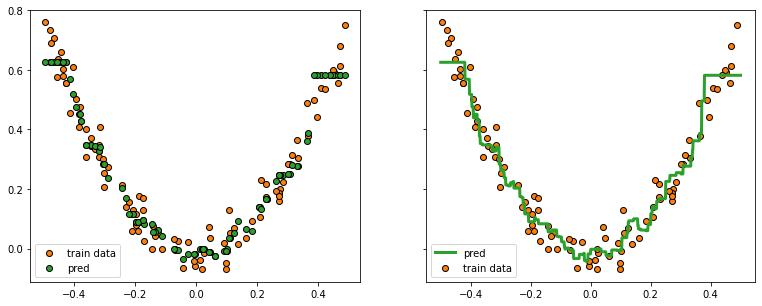

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True)

ax[0].scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k', label="train data")
ax[0].scatter(X_reg, pred_X_reg_knn_mse, marker='o', color='C2', edgecolor='k', label="pred")
ax[0].legend()

ax[1].scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k', label="train data")
ax[1].plot(x, pred_x_reg_knn_mse, color='C2', lw=3, label="pred")
ax[1].legend()

plt.show()

# fig.savefig("reg_knn_mse_lrate.png", dpi=image_dpi, bbox_inches='tight')

결과를 보면 그럴듯 하게 회귀된 것을 확인할 수 있습니다. 여기서 각 학습단계에 대한 손실도 그려보면

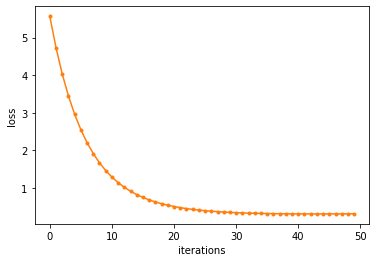

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_reg_knn_mse['loss_values'], '.-', color='C1')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
plt.show()

# fig.savefig("reg_knn_mse_lrate_loss.png", dpi=image_dpi, bbox_inches='tight')

단계별 손실함수 값도 안정적으로 줄어들고 있는 것을 확인할 수 있습니다.

보통 개별 학습기로 결정 트리를 사용하고 사이킷-런도 내부 예측기가 결정트리로 구현되어 있으므로 결정트리로 다시 시도해보겠습니다.

### `DecisionTreeRegressor` 이용

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

# learning_rate = 'linesearch'
learning_rate = 0.1
gb_reg_tree_mse = train_gradient_boost(X_reg, y_reg, h, M=50, 
                                   lr=learning_rate, loss=squared_loss)
pred_X_reg_tree_mse = predict(X_reg, gb_reg_tree_mse)
pred_x_reg_tree_mse = predict(x, gb_reg_tree_mse)

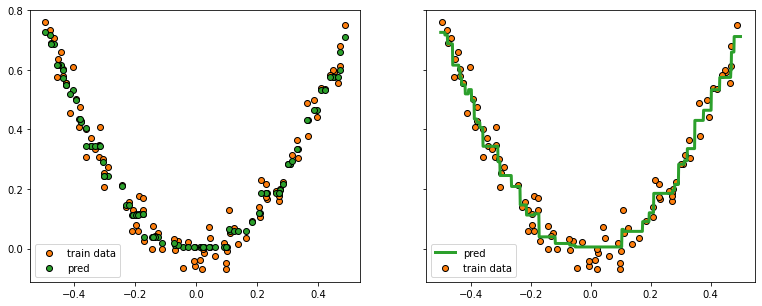

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, sharey=True)

ax[0].scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k', label="train data")
ax[0].scatter(X_reg, pred_X_reg_tree_mse, marker='o', color='C2', edgecolor='k', label="pred")
ax[0].legend()

ax[1].scatter(X_reg, y_reg , marker='o', color='C1', edgecolor='k', label="train data")
ax[1].plot(x, pred_x_reg_tree_mse, color='C2', lw=3, label="pred")
ax[1].legend()

plt.show()

# fig.savefig("reg_tree_mse_lrate.png", dpi=image_dpi, bbox_inches='tight')

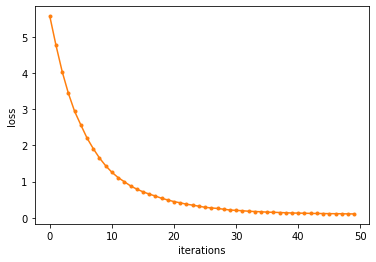

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_reg_tree_mse['loss_values'], '.-', color='C1')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
plt.show()

# fig.savefig("reg_tree_mse_lrate_loss.png", dpi=image_dpi, bbox_inches='tight')

회귀 결과와 손실함수값을 확인해보면 문제없이 잘 작동하는 것 같습니다.

이렇게 간단한 실험을 통해 약한 학습기는 knn, 트리 모델 모두 상관없이 잘 작동한다는 약한 학습기의 일반성을 확인해봤습니다. 

### sklearn 사용

지금까지 직접 코딩한 버전을 바닐라 버전이라 칭하고 사이킷런을 사용해서 동일한 문제를 풀어보겠습니다.

사이킷런에서 제공하는 `GradientBoostingRegressor`를 사용합니다. 여기서 각 개별 약한 학습기를 따로 지정할 수 없고 무조건 결정트리가 사용되는데 트리 분기 기준으로 `criterion='squared_error`를 사용하여 트리의 작동방식을 검증하겠습니다.

In [ ]:
# 모델 로드
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# 동일 조건으로 모델 생성과 fit
learning_rate = 0.1
gb_reg_sk = GradientBoostingRegressor(criterion='squared_error', 
                                 max_depth=2, n_estimators=50, 
                                 learning_rate=learning_rate)
gb_reg_sk.fit(X_reg,y_reg)

GradientBoostingRegressor(criterion='squared_error', max_depth=2,
                          n_estimators=50)

In [ ]:
# 예측
pred_x_reg_sk = gb_reg_sk.predict(x)
pred_x_reg_sk.shape

(1000,)

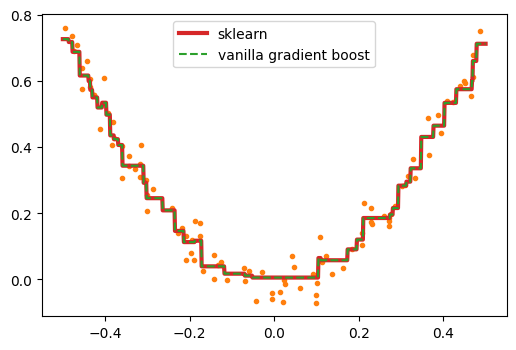

In [ ]:
# 그림 확인
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X_reg, y_reg , '.', color='C1')
ax.plot(x, pred_x_reg_sk, color='C3', lw=3, label='sklearn')
ax.plot(x, pred_x_reg_tree_mse, '--', color='C2', label='vanilla gradient boost')

ax.legend()
plt.show()

# fig.savefig("reg_tree_mse_sklearn.png", dpi=image_dpi, bbox_inches='tight')

사이킷런 예측과 직접 만든 예측을 비교해보면 동일한 것을 알 수 있습니다. 정확히 확인하게 위해 예측을 서로 비교해보면

In [ ]:
np.sum((pred_x_reg_sk - pred_x_reg_tree_mse)**2)

0.0

0이 되어 두 예측 결과는 완전히 동일함을 알 수 있습니다.

#### 사이킷런 결과 분석

이제 사이킷런이 만들어낸 첫번째 학습기와 두번째 학습기를 직접 확인하면서 내부적으로 어떻게 구현되었는지 확인해보도록 하겠습니다. 이미 확인한 결과를 통해 예상해보면 직접 만든 구현과 크게 다르지 않을 것 같습니다.

사이킷런 그래디언트 부스팅 객체에는 `gb_reg_sk.init_`에 무조건 평균을 예측하는 `DummyRegressor()` 학습기 있고 `gb_reg_sk.estimators_`에 (M,1)인 어레이로 학습기가 순서대로 들어 있습니다. 그러니까 더미 포함 총 M+1개가 있는 것입니다.

초기 더미 예측:0.265458, 학습세트 타겟평균:0.265458


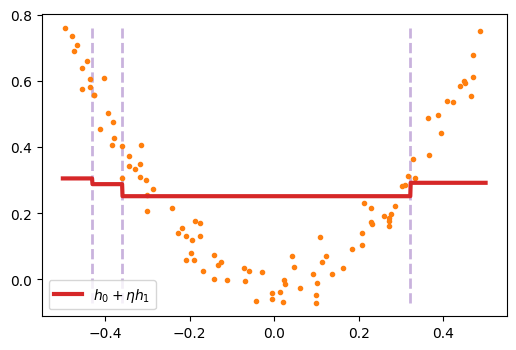

In [ ]:
# 첫번째 트리의 예측

y_reg_mean = y_reg.mean()
print(f"초기 더미 예측:{np.unique(gb_reg_sk.init_.predict(X_reg))[0]:.6f}, \
학습세트 타겟평균:{y_reg_mean:.6f}")

# 더미 예측에 학습률만큼 곱한 첫번째 예측기의 예측을 더함
h_1 = gb_reg_sk.estimators_[0,0]
pred_1 = gb_reg_sk.init_.predict(x) + learning_rate*h_1.predict(x)

# 그림으로 확인
fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X_reg, y_reg , '.', color='C1')
ax.plot(x, pred_1, color='C3', lw=3, label=r'$h_0 + \eta h_1$')

for thr in h_1.tree_.threshold:
    if X_reg.min() < thr < X_reg.max():
        ax.vlines(thr, ymin=y_reg.min(), ymax=y_reg.max(), 
                  ls='--', color='C4', lw=2, alpha=0.5)

ax.legend()
plt.show()

# fig.savefig("gb_reg_sk_h0h1.png", dpi=image_dpi, bbox_inches='tight')

위 그림은 사이킷런이 학습한 모델 `gb_reg_sk`의 더미 학습기와 첫번째 학습기가 만들어낸 예측 $h_0(x) + \eta h_1(x)$을 그린 것입니다. 여기서 스탭사이즈는 고정 학습률을 사용했기 때문에 $\eta$라 표현했습니다. 첫번째 트리 $h_1(x)$는 세번 분기한것을 알 수 있습니다. 이 트리를 직접 그려보면 다음과 같습니다.

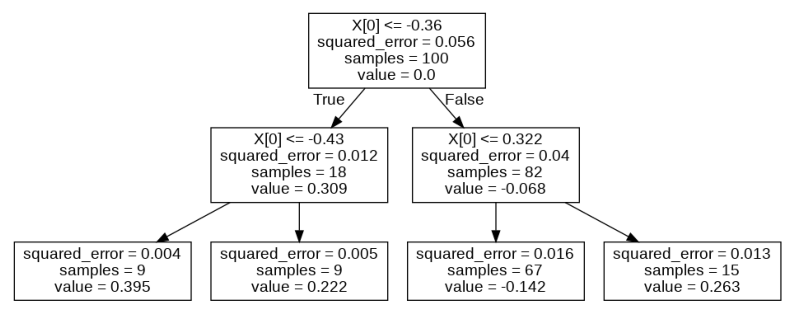

In [ ]:
# h_1을 시각화
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.axes()

# 트리 그림 그리기
dot_data = export_graphviz(h_1, out_file=None, max_depth=2)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax.imshow(tree_img)
ax.axis('off')

plt.show()

# fig.savefig("gb_reg_sk_h1.png", dpi=image_dpi, bbox_inches='tight')

그림으로 표현된 첫번때 트리 `h_1`을 보고 각 노드에 출력값 `squared_error`와 `value`를 계산해보겠습니다.

In [ ]:
# 첫번째 트리의 타겟은 더미 예측기의 출력인 y_reg_mean과의 차이가 됨
residual_1  = y_reg - y_reg_mean
print(f"root value={residual_1.mean():.3f}")

# 첫번째 분류에서 벨류값이 그냥 평균이냐?
depth1_first_node_idx = X_reg[:,0]<=-0.36
depth1_first_node_target = residual_1[depth1_first_node_idx]

# squared_error은 평균과 각 타겟 사이의 mse
print("첫번째 트리의 depth1 first node 결과")
print(f"squared_error={np.mean((depth1_first_node_target - depth1_first_node_target.mean())**2):.3f}") 
print(f"value={depth1_first_node_target.mean():.3f}") # 출력값은 그냥 평균

root value=0.000
첫번째 트리의 depth1 first node 결과
squared_error=0.012
value=0.309


루트노드에 모인 샘플의 타겟은 더미 학습기 예측과 최초 타겟값의 차이, 잔차(residual)이며 이를 평균한 값이 루트노드의 `value`로 출력되었음을 알 수 있습니다. 깊이1에서 첫번째 노드에 나타난 `value=0.309`는 루트노드에 있는 샘플이 `X[0]<=-0.36`이라는 조건을 통해 이 노드에 모인 샘플들의 타겟값 평균임을 확인할 수 있습니다. 깊이1에서 첫번째 노드에 나타난 `squared_error=0.012`는 앞서 구한 `value`값과 노드에 모인 샘플들의 타겟값 사이에서 계산되는 오차제곱합임을 알 수 있습니다.

이제 `h_1`트리의 실제 출력을 담당하는 리프노드에서 값도 확인해보겠습니다.

In [ ]:
depth2_first_node_idx = X_reg[:,0] <= -0.43

depth2_first_node_target = residual_1[depth1_first_node_idx & depth2_first_node_idx]

print("첫번째 트리의 depth2 first node 결과")
print(f"squared_error: {np.mean((depth2_first_node_target - depth2_first_node_target.mean())**2):.3f}") 
print(f"value: {depth2_first_node_target.mean():.3f}") # 출력값은 그냥 평균


첫번째 트리의 depth2 first node 결과
squared_error: 0.004
value: 0.395


깊이1의 첫번째 노드처럼 그냥 노드 샘플의 평균을 value로 출력하는 일반적인 회귀 트리임을 확인할 수 있습니다. 이렇게 그래디언트 부스팅이 회귀 문제에 적용되면 예측과 타겟의 잔차를 다시 타겟으로 하는 회귀 트리의 연속적인 모임이라는 것을 알 수 있습니다.

앞서 복잡한 식을 통해 유도했던 과정이 그대로 적용됨을 실제 사이킷런 학습 결과를 분석하면서 확인할 수 있었습니다.

## 분류

이제 위에서 만든 함수를 수정없이 그대로 이진분류 문제에 적용해보겠습니다. 이진분류 문제에 적용하게 되면 타겟은 0 또는 1이 되며 잔차는 0 또는 1과 예측값의 차이가 될 것입니다. 원칙적으로 이 문제에 대한 학습기는 0보다 작은값 또는 1보다 큰값을 출력하지 않아야 합니다. 현재 작성된 함수에 그런 제약조건을 고려하지 않아서 1보다 큰값, 0보다 작은 값이 출력될 수 있지만 그것과 별개로 손실을 줄이도록 만들어졌으므로 전반적으로는 잘 작동할 것으로 예상됩니다. 

두가지 예제를 통해 확인해보겠습니다.


### 첫번째 예제

첫번째 예제는 사이킷런의 `make_gaussian_quantiles` 함수를 통해 생성합니다.

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py

from sklearn.datasets import make_gaussian_quantiles

X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X_clf1 = np.concatenate((X1, X2))
y_clf1 = np.concatenate((y1, -y2 + 1))

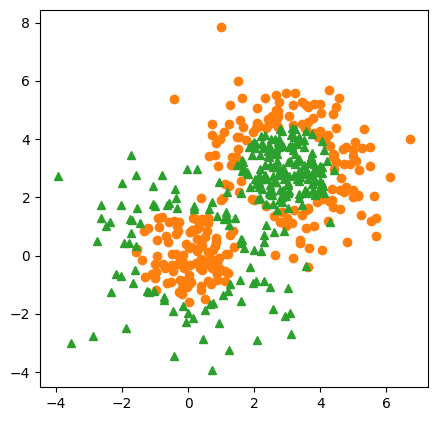

In [ ]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X_clf1[y_clf1==0][:, 0], X_clf1[y_clf1==0][:, 1], 'o', color='C1')
ax.plot(X_clf1[y_clf1==1][:, 0], X_clf1[y_clf1==1][:, 1], '^', color='C2')
ax.axis('tight')
plt.show()


앞서 만들어둔 함수 `train_gradient_boost`는 오차제곱합 손실함수에 대한 그래디언트를 계산하므로 분류 문제에서도 타겟 0, 1이 회귀해야할 실제 값입니다. 따라서 개별 학습기도 여전히 Regressor로 지정해야 합니다. 이런 이유로 그래디언트 부스팅 알고리즘의 다른 이름이 그래디언트 부스팅 회귀트리gradient boosting regression tree가 되는 것입니다.

#### `DecisionTreeRegressor` 이용

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 0.2
gb_clf1_tree_mse = train_gradient_boost(X_clf1, y_clf1, h, M=50, 
                                        lr=learning_rate, loss=squared_loss)

- 실행 결과를 그림으로 확인해보자.

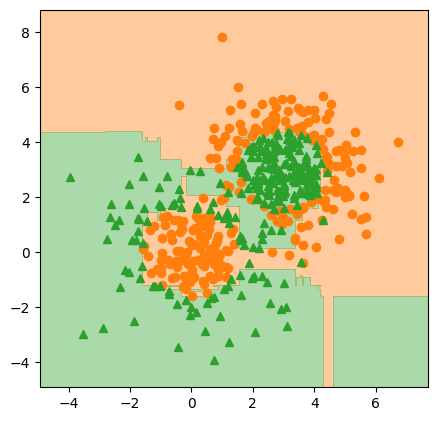

In [ ]:
# 그림으로 확인
X = X_clf1
y = y_clf1

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred_x_clf1_tree_mse = predict(X_grid, gb_clf1_tree_mse)

Z = np.zeros(X_grid.shape[0])
Z[pred_x_clf1_tree_mse >= 0.5] = 1.
Z = Z.reshape(X1.shape)

fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.axis('tight')

plt.show()

pred_x_clf1_tree_mse = Z.copy()

# fig.savefig("gb_clf1_tree_mse.png", dpi=image_dpi, bbox_inches='tight')

생각보다 나쁘지 않게 잘되는 것을 확인할 수 있습니다. 학습시키는 함수로부터 각 단계에서 발생한 로스값을 돌려받았으므로 그림으로 그려보겠습니다.

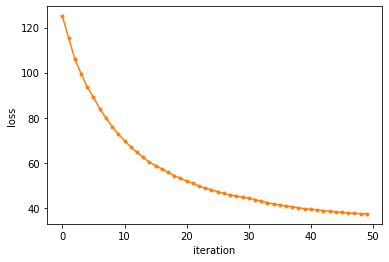

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_clf1_tree_mse['loss_values'], '.-', color='C1')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')


plt.show()

# fig.savefig("gb_clf1_tree_mse_loss.png", dpi=image_dpi, bbox_inches='tight')

손실도 꾸준히 잘 감소하는 것을 확인할 수 있습니다. 재미삼아 kNN을 개별 예측기로 사용해서 실험 해보겠습니다.



#### `KNeighborsRegressor` 이용

In [ ]:
h = KNeighborsRegressor(n_neighbors=10)

learning_rate = 0.1
gb_clf1_knn_mse = train_gradient_boost(X_clf1, y_clf1, h, M=25, 
                                       lr=learning_rate, loss=squared_loss)

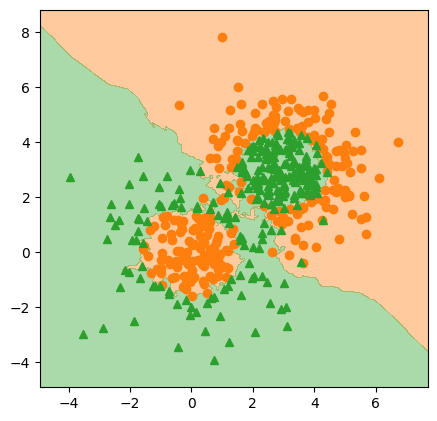

In [ ]:
# 그림으로 확인
X = X_clf1
y = y_clf1

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred_x_clf1_knn_mse = predict(X_grid, gb_clf1_knn_mse)

Z = np.zeros(X_grid.shape[0])
Z[pred_x_clf1_knn_mse >= 0.5] = 1.
Z = Z.reshape(X1.shape)

fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.axis('tight')

plt.show()

# fig.savefig("gb_clf1_knn_mse.png", dpi=image_dpi, bbox_inches='tight')

kNN 결과도 나쁘지 않습니다. 손실도 그려보겠습니다.

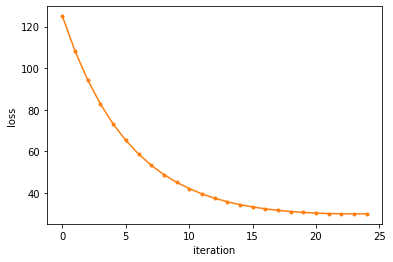

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_clf1_knn_mse['loss_values'], '.-', color='C1')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')


plt.show()

# fig.savefig("gb_clf1_knn_mse_loss.png", dpi=image_dpi, bbox_inches='tight')

`k`값, 학습률, 개별 학습기 수 `M`을 적당히 잘 지정하면 나쁘지 않은 결과를 얻을 수 있습니다. 분류된 결과는 결정 트리를 기반으로 하는 경우와는 사뭇 다른 모습인것도 재미있는 부분입니다.

이제 사이킷런으로 같은 데이터에 대해서 실행해보겠습니다.

#### sklearn 사용

사이킷런의 `GradientBoostingClassifier`를 사용합니다. 단 여기서는 어떤 이유로 인해 학습률을 1로 지정하도록 하겠습니다. 1로 두는 이유는 이 글 마지막에 이야기하도록 하겠습니다.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rate = 1.0
# 옵션 criterion 은 약한 학습기
gb_clf1_sk = GradientBoostingClassifier(criterion='squared_error', 
                                        learning_rate=learning_rate, 
                                        n_estimators=50, max_depth=2)

In [ ]:
gb_clf1_sk.fit(X_clf1, y_clf1)

GradientBoostingClassifier(criterion='squared_error', learning_rate=1.0,
                           max_depth=2, n_estimators=50)

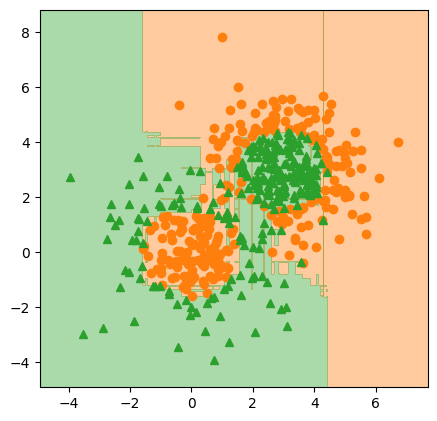

In [ ]:
# 그림으로 확인
X = X_clf1
y = y_clf1

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = gb_clf1_sk.predict(X_grid)
Z = Z.reshape(X1.shape)

fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.axis('tight')

plt.show()

pred_x_clf1_sk = Z.copy()

# fig.savefig("gb_clf1_sk.png", dpi=image_dpi, bbox_inches='tight')

결정트리를 개별 학습로 사용한 결과와 크게 다르지 않은 결과를 확인할 수 있습니다. 하지만 회귀의 경우처럼 완벽하게 동일하지는 않기 때문에 사이킷런 학습 과정은 앞서 설명한 그래디언트 부스팅의 과정과 약간 다를 것이란 것을 짐작할 수 있습니다.

조금 더 간단한 두 번째 예제를 하나 더 실행하고 두 번째 예제를 가지고 분석을 해보도록 하겠습니다.

### 두번째 예제

In [ ]:
from sklearn.datasets import make_moons

X_clf2, y_clf2 = make_moons(n_samples=100, noise=0.25, random_state=3)

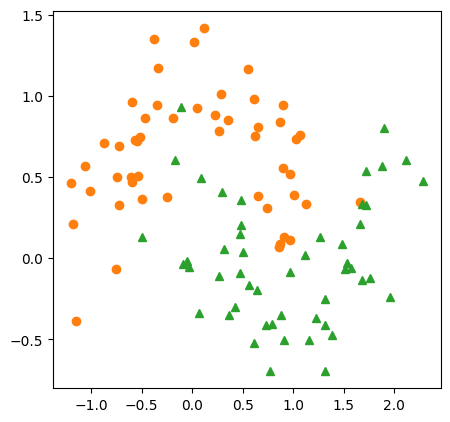

In [ ]:
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X_clf2[y_clf2==0][:, 0], X_clf2[y_clf2==0][:, 1], 'o', color='C1')
ax.plot(X_clf2[y_clf2==1][:, 0], X_clf2[y_clf2==1][:, 1], '^', color='C2')
ax.axis('tight')
plt.show()

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 0.2
gb_clf2_tree_mse = train_gradient_boost(X_clf2, y_clf2, h, M=50, 
                                        lr=learning_rate, loss=squared_loss)

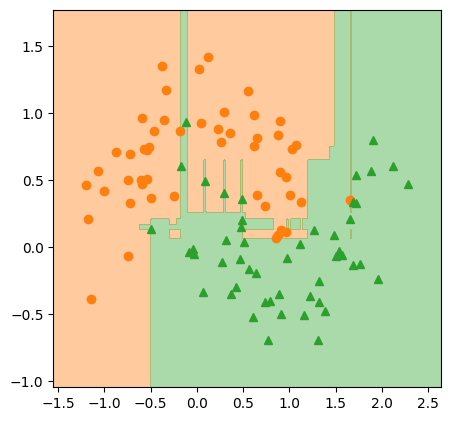

In [ ]:
# 그림으로 확인
X = X_clf2
y = y_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred_x_clf2_tree_mse = predict(X_grid, gb_clf2_tree_mse)

Z = np.zeros(X_grid.shape[0])
Z[pred_x_clf2_tree_mse >= 0.5] = 1.
Z = Z.reshape(X1.shape)

fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('tight')

plt.show()

pred_x_clf2_tree_mse = Z.copy()


# fig.savefig("gb_clf2_tree_mse.png", dpi=image_dpi, bbox_inches='tight')

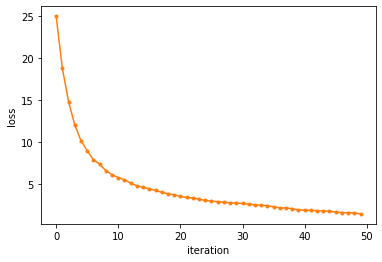

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_clf2_tree_mse['loss_values'], '.-', color='C1')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')


plt.show()


# fig.savefig("gb_clf2_tree_mse_loss.png", dpi=image_dpi, bbox_inches='tight')

이번 예제도 예측 결과나 손실이 줄어드는 과정이 썩 나쁘지 않습니다. 사이킷런으로 실행해서 결과를 비교해봅시다.

#### sklearn 사용

이전과 동일하게 실행하며 이번에도 학습률을 1로 두겠습니다.

In [ ]:
learning_rate = 1.0
gb_clf2_sk = GradientBoostingClassifier(criterion='squared_error', 
                                 learning_rate=learning_rate, 
                                  n_estimators=50, max_depth=2)

In [ ]:
gb_clf2_sk.fit(X_clf2, y_clf2)

GradientBoostingClassifier(criterion='squared_error', learning_rate=1.0,
                           max_depth=2, n_estimators=50)

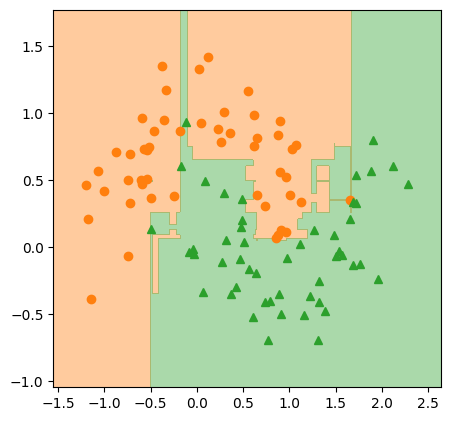

In [ ]:
# 그림으로 확인
X = X_clf2
y = y_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

Z = gb_clf2_sk.predict(X_grid)
Z = Z.reshape(X1.shape)

fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.axes()

ax.plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax.plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('tight')

plt.show()

pred_x_clf2_sk = Z.copy()

# fig.savefig("gb_clf2_sk.png", dpi=image_dpi, bbox_inches='tight')

역시 비슷한 결과를 얻을 수 있지만 완전히 동일하지 않은 것을 확인할 수 있습니다. 무엇이 다른지 확인하기 위해 회귀때 처럼 첫번째 트리를 분석해보기로 하겠습니다.

#### 사이킷런 결과 분석

In [ ]:
# 첫번째 트리의 예측
y_mean = y.mean()
print(f"초기 더미 예측:{np.unique(gb_clf2_sk.init_.predict(X))[0]:.6f}, 학습세트 타겟평균:{y_mean:.6f}")

초기 더미 예측:0.000000, 학습세트 타겟평균:0.500000


초기 타겟의 평균은 0.5인데 더미 예측기가 타겟의 평균을 출력하지 않는것을 확인할 수 있습니다. 초기 더미 예측기가 0을 출력한 것은 타겟 평균 0.5를 확률값으로 보고 이에 대한 로짓값을 출력하기 때문입니다.



In [ ]:
# 위에 더미 예측기의 출력값이 0 이 나오는 이유는? 
# 예측기는 확률값을 출력하지 않고 로짓을 출력한다.
p = y_mean
np.log(p / (1-p))

0.0

이 사실로부터 분류문제에서 각 학습기는 로짓을 출력한다고 가정한 것을 알 수 있습니다. 마치 로지스틱 회귀의 선형함수 부분과 같은 역할을 한다고 생각할 수 있습니다. 로지스틱회귀에서도 선형식을 이용해서 [0,1]로 바운드되지 않는 로짓값을 출력하고 이를 로지스틱 시그모이드 함수에 입력하여 최종 출력을 분류문제에 적합한 확률로 바꾸는데 그래디언트 부스팅도 유사하게 작동하는 것입니다.

개별 학습기가 확률을 바로 출력한다고 하면 [0,1]로 바운드된 값을 출력해야 하는데 이렇게 하기 위해서는 제약조건을 걸어야 합니다. 그것보다 출력을 로짓으로 가정하고 $(-\infty, \infty)$로 언바운드된 값을 출력하게 하는 편이 더 간편합니다.

이제 $F_m(\mathbf{x})$가 로짓을 출력하는 함수이므로 로짓을 입력으로 받는 목적함수를 정의 해야 합니다.


### Deviance loss

이진분류 문제에서 로그 가능도는 다음과 같습니다.

$$
\ell = y \log(p) + (1-y) \log(1 - p)
$$

위 식에서 이 식에 입력되는 값이 확률임을 분명히 하기 위해 $p$로 표기 했습니다. 적당히 전개를 합니다.

$$
\begin{aligned}
\ell &= y \log(p) + (1-y) \log(1 - p) \\[5pt]
&= y \log(p) + \log(1 - p) - y \log(1 - p) \\[5pt]
&= \log(1 - p) + y ( \log(p) - \log(1 - p)) \\[5pt]
&= \log(1 - p) + y \log \left( \frac{p}{1-p} \right) 
\end{aligned} \tag{[1]}
$$

한편 $p$와 로짓 $z$의 관계는 다음과 같으므로 (확률은 더해서 1이 된다는 것을 이용)

$$
p = \frac{e^{z}}{1+e^{z}} \implies 1-p = \frac{1}{1+e^{z}}
$$

두번째 결과에 로그를 취하면

$$
\log(1 - p) = \log \left( \frac{1}{1 + e^{z}} \right) =  -\log (1+ e^{z}) \tag{[2]}
$$

이 결과를 [1]에 대입하면 

$$
\ell =  -\log (1+ e^{z}) + y \log \left( \frac{p}{1 - p} \right)  
$$

여기서 $\log \left( \frac{p}{1 - p} \right)  = z$이므로


$$
\ell =  y  z- \log (1+ e^{z}) 
$$

손실로 만들기위애 가능도에 마이너스를 곱하면

$$
L(y, z) = -y  z + \log (1+ e^{z}) 
$$



그리고 가정에 의해

$$
z = F(\mathbf{x}) 
$$

이므로 최종적으로 손실함수는 다음처럼 주어집니다.

$$
L(y, F(\mathbf{x})) = -y F(\mathbf{x}) + \log \left( 1+ e^{F(\mathbf{x})} \right) \tag{[3]}
$$




이제 [3]를 $F(\mathbf{x})$에 대해 미분해보면


$$
\begin{aligned}
\frac{\partial}{\partial \, F(\mathbf{x})} L(y, F(\mathbf{x}))  &=  -y F(\mathbf{x}) + \log \left( 1+ e^{F(\mathbf{x})} \right) \\
&= -y + \frac{e^{F(\mathbf{x})}}{1+ e^{F(\mathbf{x})}} 
\end{aligned}
$$


그래디언트를 구하기 위해 그래디언트가 정의되는 포인트를 $F_{m-1}(\mathbf{x})$로 설정하면

$$
\left[ \frac{\partial}{\partial \, F(\mathbf{x})} L(y, F(\mathbf{x})) \right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})} = -y + \frac{e^{F_{m-1}(\mathbf{x})}}{1+ e^{F_{m-1}(\mathbf{x})}} = -y + p_{m-1}(\mathbf{x})
$$

가 됩니다. 

강하방향으로 만들기 위해 마이너스를 곱하면

$$
-\left[ \frac{\partial}{\partial \, F(\mathbf{x})} L(y, F(\mathbf{x})) \right]_{F(\mathbf{x})= F_{m-1}(\mathbf{x}) } = y - p_{m-1}(\mathbf{x})
$$

따라서 pseudo-response는 다음과 같습니다.

$$
-g_m(\mathbf{x}_i) = y_i - p_{m-1}(\mathbf{x}_i) \tag{[4]}
$$

이 식에서 $p_{m-1}$은 $F_{m-1}(\mathbf{x})$가 만들어낸 출력 로짓을 확률로 변환한 값을 의미합니다. 그러고 보면 이번에도 역시 그래디언트의 유사값analogue이 확률의 잔차가 됨을 알 수 있습니다. 그래서 역시 이번에도 pseudo-residual이 됩니다.


$$
\left[ \frac{\partial}{\partial \, F(\mathbf{x})} \left( -y_i F(\mathbf{x}_i) + \log \left(1+e^{F(\mathbf{x}_i)} \right) \right) \right]_{F(\mathbf{x})=F_{m-1}(\mathbf{x})} =  p_{m-1}(\mathbf{x}_i) - y_i 
$$

### 직접구현 2

위에서 유도한 새로운 손실함수에 대해서 코드를 작성했습니다. 뭔가 복잡하게 유도된 듯 하지만 결론은 식[4]이고 놀랍게도 식[4]는 기존 방식에서 잔차를 구하는 것과 동일합니다. 다른 점은 잔차를 계산하기전에 모델의 출력을 로짓에서 확률로 바꾸는 것 밖에 없습니다.

In [ ]:
logit = lambda p: np.log(p / (1-p))
proba = lambda z: 1 / (1+np.exp(-z))

# 그래디언트부스팅 직접 만들기[+]
def train_gradient_boost_clf(X, y, h, M=10, lr=0.1, loss=None):
    """
    X: train samples (N,D), N: # of samples, D: the dimension of a sample
    y: target
    h: weak learner instance
    M: # of week learner (except for the first dummy learner)
    lr: float: learning_rate, 'linesearch': linesearch
    loss: loss function whose args are predictions and ground truth
    """
    loss_values = []

    # step 1
    # 알고리즘에서처럼 상수로 첫번째 예측기를 정한다,  m=0
    # 단 이번에는 평균에 대한 로짓을 함수값으로 가진다.
    H = [ logit(y.mean()) ] 
    Fm_1 = np.ones(X.shape[0])*H[0]
    steps = [None, ]

    do_linesearch = True if type(lr) is str else False

    # 학습
    for m in range(1, M+1):# 최초 더미 예측기 제외 M개
        # 각 단계의 학습기에서 만들어낸 로스 저장
        # 여기서는 로스값을 저장할 목적으로 loss를 사용할 뿐
        # 실제 계산을 위해 사용하는 것은 아님
        # 이 코드에서 실제 loss의 미분은 squared loss로 하드코딩
        if loss is not None:
            loss_values.append( loss(y, Fm_1) )

        # step 2 그래디언트의 값 N를 구함 pseudo-residual
        # 위 유도 결과에 따라 잔차는 다시 확률로 바꿔서 계산
        r_im = y - proba(Fm_1)
        
        # step 3 구해진 잔차 r_im에 대해서 학습기 hm을 학습
        h_ = clone(h)
        H.append( h_.fit(X, r_im) )

        # step 4 & 5
        if do_linesearch:
            def f_rho(rho) :
                return loss(y, Fm_1 + rho * H[-1].predict(X))

            rho = gss(f_rho)
            steps.append(rho)

            Fm_1 += steps[-1]*H[-1].predict(X)
        else:
            Fm_1 += lr*H[-1].predict(X)
    
    if do_linesearch:
        return {'learners':H, 'learning_rate':steps, 'loss_values':loss_values}
    else:
        return {'learners':H, 'learning_rate':lr, 'loss_values':loss_values}

# 예측하기[+]
def predict_clf(X, gradient_boost):
    """
    X: input, (N,D)
    gradient_boost: model dict. that has been trained 
    """
    
    H = gradient_boost['learners']
    lr = gradient_boost['learning_rate']

    # 0번째 약한학습기는 모든 입력에 대해서 상수 H[0] 출력
    F = np.ones(X.shape[0])*H[0]

    # 여기서 계산되는 함수값은 로짓이다.
    for m in range(1, len(H)):
        # lr이 리스트로 구성되었으면 각 단계에서 선탐색을 한것이므로
        # 각 단계마다 결정된 스탭사이즈를 사용
        if hasattr(lr, '__iter__'):
            F += lr[m]*H[m].predict(X)
        # 그렇지 않으면 고정 러닝레이트를 사용    
        else:
            F += lr*H[m].predict(X)

    # 리턴하기 전에 확률값으로 바꾼다.
    pred = proba(F)

    return pred


다시 코딩하긴 했지만 달라진 부분은 결국 손실함수가 바뀐 부분밖에 없습니다. 이전처럼 부스팅 과정에서 손실함수 값을 가져오기 위해 앞서 유도한 deviance loss를 준비합니다.

In [ ]:
deviance_loss = lambda y, pred:  np.sum( -y*pred + np.logaddexp(0, pred) )

그런데 방금 코딩한 손실함수를 사이킷런 구현에서 살펴보면 다음처럼 되어 있습니다.

- https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09bcc2eaeba98f7e737aac2ac782f0e5f1/sklearn/ensemble/_gb_losses.py#L633

```python
-2*np.mean( y*pred - np.logaddexp(0, pred) ) 
```

사이킥런에서는 `sum()` 대신 `mean()`을 쓰고 앞에 2가 곱해져 있습니다. `mean()`을 쓴것은 별로 문제가 안되는데 앞에 2가 곱해진 것은 좀 이해하기 어렵습니다. 2가 곱해진 이유는 로그가능도가 점근적으로 카이제곱분포를 따르도록 만들기 위함이라고 합니다. 물론 여기서 이야기하고 있는 내용은 통계학에서 가설검정과는 상관없는 내용이므로 2가 곱해전 것은 손실이 2배가 된다는 것 말고는 아무 의미도 없습니다.

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 1.0
# learning_rate= 'linesearch'
gb_clf1_tree_dev = train_gradient_boost_clf(X_clf1, y_clf1, h, M=50, 
                                      lr=learning_rate, loss=deviance_loss)

pred_X_clf1_tree_dev = predict_clf(X_clf1, gb_clf1_tree_dev)

만들어진 모델을 학습데이터에 대해서 예측하여 몇개나 틀리는지 확인해보겠습니다.

아래 셀을 실행하면 결과가 나오는데 위 셀에서 선탐색을 한 경우와 안한 경우를 비교해보면 선탐색을 한 경우 모든 데이터를 다 맞추는 것을 확인할 수 있습니다. 선탐색을 하지 않으면 42개는 틀리게 됩니다.

In [ ]:
np.sum( (pred_X_clf1_tree_dev >= 0.5).astype(int) != y_clf1 )

42

이제 이전 결과와 이번 결과를 비교 해봅시다.

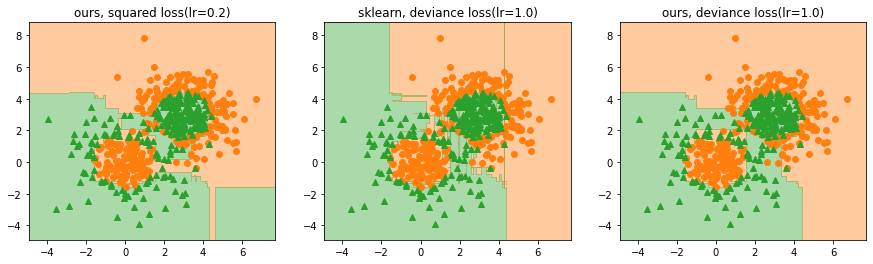

In [ ]:
# 그림으로 확인
X = X_clf1
y = y_clf1

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

# squared loss로 한것
# Z = np.zeros(X_grid.shape[0])
# Z[pred_x_clf1_tree_mse >= 0.5] = 1.
# Z = Z.reshape(X1.shape)
ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, pred_x_clf1_tree_mse, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_title('ours, squared loss(lr=0.2)')

#sklearn
ax[1].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[1].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[1].contourf(X1, X2, pred_x_clf1_sk, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_title('sklearn, deviance loss(lr=1.0)')

# deviance loss
pred_x_clf1_tree_dev = predict_clf(X_grid, gb_clf1_tree_dev)
Z = np.zeros(X_grid.shape[0])
Z[pred_x_clf1_tree_dev >= 0.5] = 1.
Z = Z.reshape(X1.shape)
ax[2].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[2].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[2].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[2].set_xlim(x_min, x_max)
ax[2].set_ylim(y_min, y_max)
ax[2].set_title(f'ours, deviance loss(lr={learning_rate})')

plt.show()

pred_x_clf1_tree_dev = Z.copy()

# fig.savefig("dv_clf1_test.png", dpi=image_dpi, bbox_inches='tight')

위 그림은 분류 1번 데이터에 대해서 squared loss와 deviance loss를 적용한 것을 비교한 그림입니다. 가운데 그림은 사이킷런으로 실행한 결과입니다. 세번째 그림이 첫번째 그림보다 가운데 그림과 조금 더 비슷하게 보입니다. 하지만 손실을 deviance loss로 바꾸고 학습률도 동일하게 두었는데도 사이킷런 결과와 완전히 일치하지 않습니다. 학습 과정중에 손실이 어떻게 줄어드는 지도 확인해보겠습니다.

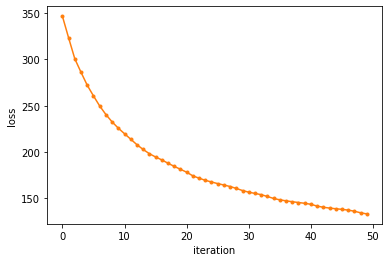

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_clf1_tree_dev['loss_values'], '.-', color='C1')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')


plt.show()

손실도 안정적으로 줄어들고 있습니다. 사이킷런 구현에 다른 뭔가가 있는 듯 해 보입니다. 계속해서 두 번째 예제에 대해서도 실험해봅시다. 

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

# learning_rate = 'linesearch'
learning_rate = 1.0
gb_clf2_tree_dev = train_gradient_boost_clf(X_clf2, y_clf2, h, M=50, 
                                      lr=learning_rate, loss=deviance_loss)
pred_X_clf2_tree_dev = predict_clf(X_clf2, gb_clf2_tree_dev)

In [ ]:
np.sum( (pred_X_clf2_tree_dev >= 0.5).astype(int) != y_clf2 )

0

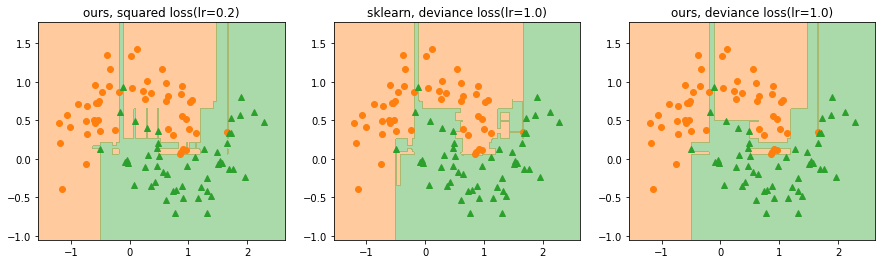

In [ ]:
# 그림으로 확인
X = X_clf2
y = y_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)

# squared loss로 한것
# Z = Z.reshape(X1.shape)
ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, pred_x_clf2_tree_mse, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_title('ours, squared loss(lr=0.2)')

#sklearn
ax[1].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[1].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[1].contourf(X1, X2, pred_x_clf2_sk, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_title('sklearn, deviance loss(lr=1.0)')

# deviance loss
pred_x_clf2_tree_dev = predict_clf(X_grid, gb_clf2_tree_dev)
Z = np.zeros(X_grid.shape[0])
Z[pred_x_clf2_tree_dev >= 0.5] = 1.
Z = Z.reshape(X1.shape)
ax[2].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[2].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[2].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[2].set_xlim(x_min, x_max)
ax[2].set_ylim(y_min, y_max)
ax[2].set_title(f'ours, deviance loss(lr={learning_rate})')

plt.show()

# fig.savefig("dv_clf2_test.png", dpi=image_dpi, bbox_inches='tight')

여기서도 예제1과 마찬가지로 deviance loss를 쓴 경우 사이킷런과 좀 더 닮은 더 안정적인 결정 영역을 만드는 것처럼 보입니다. 하지만 이번 예도 아직 sklearn의 결과와는 약간 차이가 있습니다. 손실이 안정적으로 떨어지지 않아서 그런지 단계별 손실값도 다시 한번 그려보겠습니다.

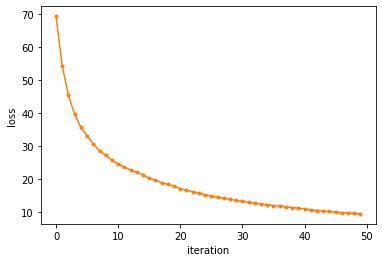

In [ ]:
fig = plt.figure()
ax = plt.axes()

ax.plot(gb_clf2_tree_dev['loss_values'], '.-', color='C1')

ax.set_xlabel('iteration')
ax.set_ylabel('loss')


plt.show()

손실도 안정적으로 줄어들고 있습니다. 그렇다면 이제 남은 것은 무엇일까요? 무엇이 문제인지 알아보기 위해 여기서 사이킷런의 $h_1(x)$를 그려보도록 합시다.



#### 사이킷런 결과 분석(계속)

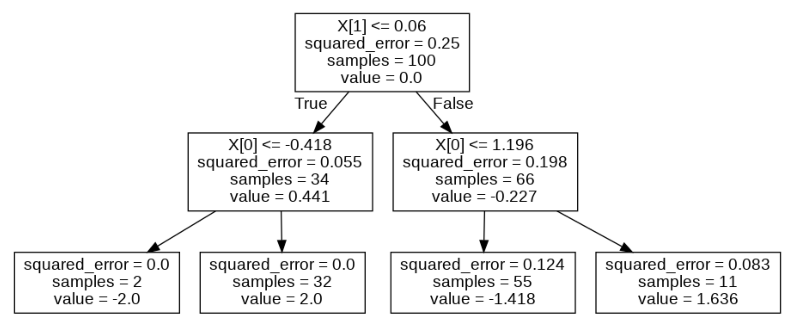

In [ ]:
# h_1을 시각화
h_1 = gb_clf2_sk.estimators_[0,0]

fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.axes()
# 트리 그림 그리기
dot_data = export_graphviz(h_1, out_file=None, 
                           max_depth=3, precision=3)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax.imshow(tree_img)
ax.axis('off')
plt.show()

# fig.savefig("gb_clf_sk_h1.png", dpi=image_dpi, bbox_inches='tight')

위처럼 그려지는 $h_1(x)$ 대해서 이전에 했던것처럼 각 노드별로 결정되는 숫자값을 조사해보도록 합시다. 루트 노드와 깊이 1에서 첫번째 노드에 대한 `squared_error`, `value`를 계산해보겠습니다.

In [ ]:
# 첫번째 회귀트리 h_1(x)이 타겟으로 삼을 확률의 잔차
# 잔차는 타겟 y와 h_0(x)가 출력한 값을 확률료 바꾼 값과의 차이
# 첫단계에서 그값은 y의 평균이 된다.
residual_1 = y - y_mean

# 루트 노드 squared_error, value
# value는 노드에 모인 샘플들의 평균
root_mean = residual_1.mean()

root_squared_error = np.mean((residual_1 - root_mean)**2)
print(f"root squared_error={root_squared_error:.3f}")
print(f"root value={root_mean:.3f}")

# 깊이1 첫번째 노드
depth1_first_node_idx = X_clf2[:,1]<=0.06
depth1_first_node_target = residual_1[depth1_first_node_idx]

# squared_error은 평균과 각 타겟 사이의 mse
print("첫번째 트리의 depth1 first node 결과")
print(f"squared_error: {np.mean((depth1_first_node_target - depth1_first_node_target.mean())**2):.3f}") 
print(f"value: {depth1_first_node_target.mean():.3f}") 


root squared_error=0.250
root value=0.000
첫번째 트리의 depth1 first node 결과
squared_error: 0.055
value: 0.441


결과를 보면 `value`는 해당 노드에 모인 샘플의 타겟 평균, `squared_error`은 타겟 평균과의 제곱오차 평균임을 알 수 있습니다.

이제 두번째 단계로 리프노드를 조사해봅시다. 이전과 조사방식은 똑같습니다.

In [ ]:
# 깊이2 첫번째 노드
depth2_first_node_idx = X_clf2[:,0]<=-0.418

depth2_first_node_target = residual_1[depth1_first_node_idx & depth2_first_node_idx]
depth2_first_node_sample = X_clf2[depth1_first_node_idx & depth2_first_node_idx]

# squared_error은 평균과 각 타겟 사이의 mse
print("첫번째 트리의 depth2 first node 결과")
print(f"squared_error: {np.mean((depth2_first_node_target - depth2_first_node_target.mean())**2):.3f}") 
print(f"value: {depth2_first_node_target.mean():.3f}") 

첫번째 트리의 depth2 first node 결과
squared_error: 0.000
value: -0.500


앗! 이번에는 `squared_error`은 사이킷런과 동일하게 계산되지만 `value`는 동일하지 않습니다. 

이것으로 분류 문제에서 사이킷런이 사용하는 개별 학습기 회귀트리에서 출력하는 값은 샘플 타겟의 평균이 아니란 것을 알 수 있습니다.

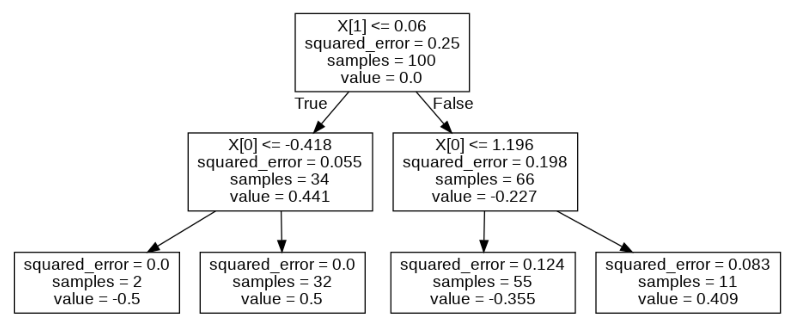

In [ ]:
my_h_1 = gb_clf2_tree_dev['learners'][1]

# h_1을 시각화
fig = plt.figure(figsize=(10,5), dpi=100)
ax = plt.axes()
# 트리 그림 그리기
dot_data = export_graphviz(my_h_1, out_file=None, 
                           max_depth=3, precision=3)
graph = graphviz.Source(dot_data, format="png")
tree_img = imread(graph.render())
ax.imshow(tree_img)
ax.axis('off')
plt.show()

# fig.savefig("gb_clf_h1.png", dpi=image_dpi, bbox_inches='tight')

### TreeBoost

앞서 knn과 결정트리를 사용해서 약한 학습기가 특정 모델로 제한될 필요가 없다는 특징을 알아봤습니다. 그런데 결정트리를 사용한다면 매 반복에서 구해지는 약한 학습기들은 출력값으로 트리의 리프노드 숫자만큼의 출력값만 가지게 됩니다. 더 쉽게 이해하기 위해 다음 그림을 봅시다.

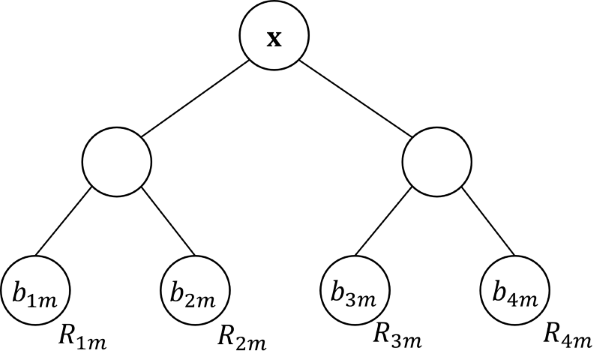

어떤 반복단계 $m$에서 결정트리로 만들어진 약한 학습기 $h_m(\mathbf{x})$가 위 그림과 같다고 할때 이 함수는 출력값을 영역 네 개로 나누게 됩니다. 이 영역을 $R_{jm}$이라고 표시합시다. $m$번째 트리의 $j$번째 영역이란 의미입니다. 전체 영역 개수는 $J_m$으로 표시합니다. 그럼 이 함수는 어떤 입력이 들어와도 출력값은 각 영역에서 계산되는 출력값 $b_{jm}$만 출력하게 됩니다. 이를 식으로 표시하면

$$
h\left(\mathbf{x}; \{b_m, R_j\}_{j=1}^{J_m} \right) = \sum_{j=1}^{J_m} b_{jm} 1(\mathbf{x} \in R_{jm}) \tag{15}
$$

처럼 쓸 수 있습니다. 위 식에서 $1()$은 입력되는 $\mathbf{x}$가 $\mathbf{x} \in R_{jm}$을 만족하면 1 아니면 0인 identity 함수입니다.



이 표현법으로 아래 모델의 업데이트 식

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \rho_m h(\mathbf{x};\mathbf{a}_m)
$$

을 다음처럼 바꿔 쓸 수 있습니다.

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \rho_m \sum_{j=1}^{J_m} b_{jm} 1(\mathbf{x} \in R_{jm}) \tag{16}
$$

식(16)에서 $b_{jm}$은 다음처럼 리프노드에 모인 샘플들의 타겟값 평균이 됩니다.

$$
b_{jm} = ave_{\mathbf{x} \in R_{jm}} \tilde{y}_i
$$

$m$번째 약한 학습기가 피팅하는 타겟은 pseudo-residual $\tilde{y}_i$이라는 것을 유념해야 합니다.

약한 학습기의 리프노트 출력이 해당 노드에 모인 샘플들의 타겟 평균값이 되는, 즉 위 식에서 $b_{jm}$을 출력하는 트리는 현재 우리가 직접 코딩한 그래디언트 부스팅이 사용하고 있는 트리입니다. 그런데 사이킷런에서 사용하는 개별 트리는 이 $b_{jm}$ 값을 출력하지 않았음을 상기합시다. 그래서 지금 이 이야기를 하고 있는 것입니다. 
우리가 계산한 $h_1(\mathbf{x})$의 첫번째 리프노드 출력값은 -0.5였는데 실제 사이킷런에서 출력한 값은 -2.0이였습니다.

식(16)을 더 이해하기 편하게 그림으로 그려봅시다. 첫번째 약학 학습기가 만들어낸 잔차를 학습하는 두번째 학습기를 실제로 그려보겠습니다.

먼저 첫번째 약한 학습기로 부터 잔차를 구합니다.





In [ ]:
# r_im = y - proba(F)
residual_for_h1 = y_clf2 - proba(gb_clf2_tree_dev['learners'][0])
residual_for_h1

array([ 0.5,  0.5, -0.5,  0.5,  0.5,  0.5,  0.5, -0.5, -0.5, -0.5,  0.5,
       -0.5,  0.5,  0.5, -0.5,  0.5,  0.5, -0.5,  0.5, -0.5,  0.5, -0.5,
       -0.5, -0.5,  0.5,  0.5, -0.5,  0.5, -0.5,  0.5, -0.5, -0.5, -0.5,
       -0.5,  0.5, -0.5,  0.5,  0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
        0.5,  0.5,  0.5,  0.5,  0.5, -0.5,  0.5,  0.5,  0.5,  0.5, -0.5,
        0.5,  0.5,  0.5,  0.5,  0.5, -0.5,  0.5,  0.5,  0.5, -0.5,  0.5,
       -0.5, -0.5, -0.5, -0.5, -0.5,  0.5,  0.5, -0.5,  0.5,  0.5, -0.5,
        0.5,  0.5, -0.5,  0.5, -0.5,  0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
       -0.5,  0.5, -0.5, -0.5,  0.5, -0.5, -0.5, -0.5,  0.5,  0.5, -0.5,
       -0.5])

이렇게 구한 잔차를 데이터로 하고 그 위에 두번째 약한 학습기를 실제로 그려보면

In [ ]:
# colab 노트북을 로컬런타임에 연결했다면 이 셀을 실행 
# 호스팅 런타임이면 실행안해도 됨
# https://plotly.com/python/renderers/#setting-the-default-renderer
import plotly.io

# local에서 그냥 실행하는 상황이면 notebook, jupyterlab 으로
plotly.io.renderers.default = "colab" 

In [ ]:
# https://plotly.com/python/sliders/
# https://stackoverflow.com/questions/62397485/plotly-relabelling-animation-tick-marks-on-the-slider-bar

X = X_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 20)
yy = np.linspace(y_min, y_max, 20)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred = my_h_1.predict(X_grid)
pred = pred.reshape(X1.shape)

layout = go.Layout(
    title='Gradient H_1(x)',
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=25),
    scene = dict(
        xaxis = dict(title='x1', range=[x_min, x_max],),
        yaxis = dict(title='x2', range=[y_min, y_max],),
        zaxis = dict(title='residual', range=[-2,2],),
        aspectratio=dict(x=1, y=1, z=1)
    )
)

# Create figure
fig = go.Figure(layout=layout)
fig.add_trace(
    go.Scatter3d(
        x=X[:,0], y=X[:,1], z=residual_for_h1, 
        mode='markers',
        marker=dict(
            symbol='circle', size=3, color='#E64A45',
            line=dict(color='#000000', width=0.5),
            opacity=1.0
        ),
        name='Data', visible=True
    )
)

# Add traces, one for each slider step
rho_m = np.linspace(0, 3, 52)
for rho in rho_m:
    fig.add_trace(
        go.Surface(
            x=X_grid[:,0].reshape(X1.shape), y=X_grid[:,1].reshape(X1.shape), 
            z=pred * rho, 
            showscale=False,  opacity=1.,
            contours=dict(
                x=dict(show=True, highlight=True),
                y=dict(show=True,  highlight=True),
                z=dict(show=True,  highlight=True),
            ),visible=False
        )
    )

fig.data[25].visible = True

# Create and add slider
steps = []

for i in range(1, len(fig.data)):
    step = dict(
        method="update",
        args=[
            {"visible": [True] + [False] * (len(fig.data)-1)},
            # {"title": "rho: " + f"{rho_m[i-1]:.2f}"}
        ],  # layout attribute
        label=f"{rho_m[i-1]:.2f}"
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [
    dict(
        active=17,
        currentvalue={"prefix": "rho: "},
        pad={"l":10, "t": 50, "r":10, "b":10},
        steps=steps
    )
]

fig.update_layout(sliders=sliders)

fig.show()

위 처럼 그러집니다. 위 그림은 식(16)에서 $\sum_{j=1}^{J_m} b_{jm} 1(\mathbf{x} \in R_{jm})$에 해당하는 부분입니다. 이 그래디언트로 선탐색을 해서 $\rho_m$을 구할텐데 위 그래프에서 `rho_m` 슬라이드 바를 움직면 스탭사이즈 `rho_m`에 따른 변화가 그려집니다.

위 그래프에서 볼 수 있는것 처럼 두번째 약한 학습기는 전체 영역을 네개로 나누고 각 영역에서 동일한 값을 출력합니다. 이 출력값을 $\gamma_{jm}$이라 두면 식(16)은 다음처럼 쓸 수 있습니다.

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) +  \sum_{j=1}^{J_m} \gamma_{jm} 1(\mathbf{x} \in R_{jm}) \tag{17}
$$

여기서 $\gamma_{jm} = \rho_{m} b_{jm}$입니다.

두번째 약한 학습기가 출력값을 식(17)처럼 출력한다는 말은 각 리프노트에 모인 샘플의 타겟값들을 평균한 값에 선탐색으로 찾아낸 스탭사이즈 $\rho_m$을 일괄적으로 곱해서 출력한다는 것입니다. 그런데 각 출력값 $\gamma_{jm}$은 완전히 분리된 값이므로 이를 각각 분리된 네개의 개별적인 기저함수separate basis function에 의한 출력값을 더한다고 생각할 수 있습니다. 예를 들어 $b_{1m}$이 변하면 $b_{2m}$이 그 영향을 받아서 같이 변하지 않는다는 의미입니다. 그 개별 기저함수의 출력값은 결국 다음처럼 손실함수 $L$을 최소화 시키는 값이 $J$개가 될 것입니다.

$$
\{\gamma_{jm}\}_{j=1}^J = \underset{\{\gamma_j\}_{i=1}^J}{\text{argmin}} \sum_{i=1}^N L \left( y_i, F_{m-1}(\mathbf{x}_i) + \sum_{j=1}^J \gamma_j 1(\mathbf{x} \in R_{jm})\right) 
$$

그런데 각 영역에서 함수값은 완전히 분리disjoint되어 있기 때문에 각 영역별로 최적화를 따로 수행해도 됩니다.

$$
\gamma_{jm} = \underset{\gamma}{\text{argmin}} \sum_{\mathbf{x}_i \in R_{jm}} L(y_i, F_{m-1}(\mathbf{x}_i) + \gamma) \tag{18}
$$









#### Newton's Method

위 식(18)을 풀기 위해 최적화 수법 중 2계법인 뉴턴메소드를 사용합니다. 테일러 시리즈 2차 근사를 하고 근사된 식을 $\gamma$로 미분하여 0으로 두고 방정식을 풉니다.

$$
\sum_{\mathbf{x}_i \in R_{jm}} L(y_i, F_{m-1}(\mathbf{x}_i) + \gamma) = \sum_{\mathbf{x}_i \in R_{jm}} \left(  L(y_i, F_{m-1}(\mathbf{x}_i)) + \gamma \frac{\partial L}{\partial F} +  \frac{1}{2} \gamma^2 \frac{\partial^2 L}{\partial F^2} + O(\gamma^3)\right)
$$

이제 $\gamma$에 대해 미분하고 $\gamma$의 2차항까지 남기면

$$
\begin{aligned}
\sum_{\mathbf{x}_i \in R_{jm}} \frac{d}{d \gamma} L(y_i, F_{m-1}(\mathbf{x}_i) + \gamma) &=  \sum_{\mathbf{x}_i \in R_{jm}} \frac{d}{d \gamma} \left(  L(y_i, F_{m-1}(\mathbf{x}_i)) + \gamma \frac{\partial L}{\partial F} +  \frac{1}{2} \gamma^2 \frac{\partial^2 L}{\partial F^2} + O(\gamma^3)\right) \\
&\approx \sum_{\mathbf{x}_i \in R_{jm}} \left( \frac{\partial }{\partial F} L(y_i + F_{m-1}(\mathbf{x}_i)) + \gamma \frac{\partial^2}{\partial^2 F} L(y_i + F_{m-1}(\mathbf{x}_i)) \right)
\end{aligned}
$$

결과를 0으로 놓고 정리합니다.

$$
\sum_{\mathbf{x}_i \in R_{jm}} \left( \frac{\partial }{\partial F} L(y_i + F_{m-1}(\mathbf{x}_i)) + \gamma \frac{\partial^2}{\partial^2 F} L(y_i + F_{m-1}(\mathbf{x}_i)) \right) = 0
$$

시그마 기호를 풀고 이항하여 정리하면

$$
\gamma = \frac{\sum_{\mathbf{x}_i \in R_{jm}} -\frac{\partial}{\partial F} L(\cdot) }{\sum_{\mathbf{x}_i \in R_{jm}} \frac{\partial^2}{\partial F^2} L(\cdot) }
$$

위 식에서 식([4])에 의해 분자는 다음과 같습니다.

$$
-\frac{\partial }{\partial F} L(y_i, F_{m-1}(\mathbf{x}_i)) = y_i - p_{m-1}(\mathbf{x}_i)
$$

위 식에서 $p_{m-1}(\mathbf{x}_i)$는 $F_{m-1}(\mathbf{x}_i)$가 출력한 로짓을 확률로 바꾼 값입니다.

이 결과를 이용해서 분모를 다음처럼 정리할 수 있습니다.

$$
\begin{aligned}
\frac{\partial^2}{\partial F^2} L(y_i, F_{m-1}(\mathbf{x}_i)) &= \frac{\partial}{\partial F} -y_i + p_{m-1}(\mathbf{x}_i) \\
&= \frac{\partial}{\partial F} \left( -y_i + \frac{e^{F_{m-1}(\mathbf{x}_i)}}{1+e^{F_{m-1}(\mathbf{x}_i)}} \right) \\
&=  \frac{\partial}{\partial F} \left( -y_i + \left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^{-1} e^{F_{m-1}(\mathbf{x}_i)} \right) \\
&= -\left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^{-2} e^{2F_{m-1}(\mathbf{x}_i)} + \left( 1+e^{F_{m-1}(\mathbf{x}_i)} \right)^{-1} e^{F_{m-1}(\mathbf{x}_i)} \\
&= \frac{-e^{2F_{m-1}(\mathbf{x}_i)}}{\left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^2} + \frac{e^{F_{m-1}(\mathbf{x}_i)}}{1+e^{F_{m-1}(\mathbf{x}_i)}} \\
&= \frac{-e^{2F_{m-1}(\mathbf{x}_i)}}{\left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^2} + \frac{e^{F_{m-1}(\mathbf{x}_i)}+e^{2F_{m-1}(\mathbf{x}_i)}}{\left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^2} \\
&= \frac{e^{F_{m-1}(\mathbf{x}_i)}}{\left(1+e^{F_{m-1}(\mathbf{x}_i)}\right)^2}=\frac{e^{F_{m-1}(\mathbf{x}_i)}}{1+e^{F_{m-1}(\mathbf{x}_i)}} \times \frac{1}{1+e^{F_{m-1}(\mathbf{x}_i)}} \\[5pt]
&= p_{m-1}(\mathbf{x}_i) \left( 1- p_{m-1}(\mathbf{x}_i) \right)
\end{aligned}
$$

정리한 분자 분모를 원래 식에 대입하면 다음과 같은 결과를 얻을 수 있습니다.

$$
\gamma_{jm} = \frac{\sum_{\mathbf{x}_i\in R_{jm}} y_i - p_{m-1}(\mathbf{x}_i) }{\sum_{\mathbf{x}_i\in R_{jm}} p_{m-1}(\mathbf{x}_i)(1-p_{m-1}(\mathbf{x}_i))} \tag{[5]}
$$

위 식의 의미는 $m$번째 결정 트리 $h_m(\mathbf{x})$는 $J_m$개의 출력을 출력하도록 학습되는데 각 출력값은 최종 리프 노드에 속하는 샘플 $\mathbf{x}_i \in R_{jm}$들을 사용해서 계산될 수 있다는 것입니다.

아래 그림은 각 영역별로 최적화를 거쳐 바로 출력값을 구한 두번째 약한학습기의 모습입니다.

In [ ]:
X = X_clf2

pred = h_1.predict(X_grid)
pred = pred.reshape(X1.shape)

data = [
    go.Scatter3d(x=X[:,0], y=X[:,1], z=residual_for_h1, mode='markers',
                marker=dict(
                    symbol='circle', size=3, color='#E64A45',
                    line=dict(color='#000000', width=0.5),
                    opacity=1.0
                ),
                name='Data'
    ),
    go.Surface(x=X_grid[:,0].reshape(X1.shape), y=X_grid[:,1].reshape(X1.shape), 
                z=pred, 
                showscale=False,  opacity=1.,
                contours=dict(
                x=dict(show=True, highlight=True),
                y=dict(show=True,  highlight=True),
                z=dict(show=True,  highlight=True),
            ),
    ),
]

layout = go.Layout(
    title='Gamma_r1',
    width=500, height=500,
    margin=dict(l=0, r=0, b=0, t=25),
    scene = dict(
        xaxis = dict(title='x1', range=[x_min, x_max],),
        yaxis = dict(title='x2', range=[y_min, y_max],),
        zaxis = dict(title='residual', range=[-2,2],),
        aspectratio=dict(x=1, y=1, z=1)
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()



이렇게 약한 학습기로 결정트리를 사용할 때 트리의 리프노드 출력값을 조절하는 방식을 TreeBoost라고 합니다.

TreeBoost 방식을 사용하면 약한 학습기를 학습시키고 난후 모델을 업데이트 할 때 선탐색을 하지 않기 때문에 훨씬 빠르게 모델을 적합시킬 수 있습니다.



지금까지 이야기한 TreeBoost를 구현하기 위해서는 보통의 `DecisionTreeRegressor`로 부터 최종 출력값을 TreeBoost에 맞도록 계산하는 추가 과정이 필요합니다. $h_m(\mathbf{x})$의 출력을 적절히 만들어내는 과정은 다음 절차로 코딩할 수 있습니다.

1. 학습된 $h_m(\mathbf{x})$을 이용하여 입력된 샘플들이 몇번 리프로 가는지 알아낸다. 즉 다음을 판단한다 $\mathbf{x}_i \in R_{jm}$

2. 1에서 얻어진 샘플들이 도착하는 리프노드 인덱스를 유일하게 만들어 리프노드 인덱스 집합을 얻는다.

3. 2에서 만든 리프노드 인덱스를 순회하면서 각 리프노드에 모이는 샘플들의 타겟(확률의 잔차)를 구하고 위 식([5])로 리프노드의 출력값을 계산한다.

위 과정을 $h_1(\mathbf{x})$에 대해서 시험적으로 코딩해보면 아래와 같습니다.

In [ ]:
# 첫번째 회귀트리 h_1(x)이 타겟으로 삼을 확률의 잔차
# 잔차는 h_0(x)가 출력한 타겟의 평균과의 차이가 된다.
residual_1 = y - y_mean
print(residual_1.shape)
# 첫번째 회귀트리 h_1(x)이 타겟으로 삼을 확률의 잔차를 
# 만들어낸 이전 트리 h_0(x)의 예측 확률
prev_proba = y_mean

####################################################
# Friedman의 "TreeBoost"에서 hm 출력 만들어 내기
####################################################
# 1. 각 샘플이 몇번 리프로 가는지 알아낸다.
leaf_idx_X = h_1.apply(X_clf2)
print("샘플들이 몇번 노드로 가는지 알아냄")
print(leaf_idx_X)

# 2. 얻어진 샘플에 대한 리프노드 인덱스를 유일하게 만들어 
#    리프노드 인덱스 집합을 얻는다.
Rm = sorted(set(leaf_idx_X))
print("\n샘플들이 도착하는 리프노드 인덱스")
print(Rm)

# 3. 2에서 만든 리프노드 인덱스를 순회하면서 
#    각 리프노드의 출력값을 계산한다.
# 트리의 전체 노드 수만큼 자리를 만든다.
hm_output = np.zeros(max(Rm)+1)
for j in Rm:
    residual = residual_1[leaf_idx_X==j]
    # 첫번째 트리의 예측확률은 값이 한개밖에 없으니니까 분모 sum()은 그냥
    # 해당 샘플 개수를 곱한다. eq([5])
    hm_output[j] =  residual.sum() / (residual.shape[0]*(prev_proba*(1-prev_proba)))

with np.printoptions(precision=3):
    print("\n계산된 리프노드의 출력")
    print(hm_output)

    # 4. 1에서 얻은 결과 인덱스를 3에서 얻은 리프노드
    #    결과에서 조회하여 최종 출력을 만든다.
    print("\n샘플들에 대한 출력")
    print(hm_output[leaf_idx_X])

(100,)
샘플들이 몇번 노드로 가는지 알아냄
[6 3 5 5 6 6 6 5 5 5 3 5 3 6 5 3 3 5 5 2 3 5 5 5 3 3 5 3 5 5 5 5 5 5 6 5 3
 3 5 5 5 5 5 5 6 3 3 3 3 5 3 3 3 3 5 3 3 6 5 5 5 5 3 3 2 3 5 5 5 5 5 5 6 5
 3 5 5 3 3 5 3 5 3 5 5 5 5 5 5 6 5 5 3 5 5 5 3 3 6 5]

샘플들이 도착하는 리프노드 인덱스
[2, 3, 5, 6]

계산된 리프노드의 출력
[ 0.     0.    -2.     2.     0.    -1.418  1.636]

샘플들에 대한 출력
[ 1.636  2.    -1.418 -1.418  1.636  1.636  1.636 -1.418 -1.418 -1.418
  2.    -1.418  2.     1.636 -1.418  2.     2.    -1.418 -1.418 -2.
  2.    -1.418 -1.418 -1.418  2.     2.    -1.418  2.    -1.418 -1.418
 -1.418 -1.418 -1.418 -1.418  1.636 -1.418  2.     2.    -1.418 -1.418
 -1.418 -1.418 -1.418 -1.418  1.636  2.     2.     2.     2.    -1.418
  2.     2.     2.     2.    -1.418  2.     2.     1.636 -1.418 -1.418
 -1.418 -1.418  2.     2.    -2.     2.    -1.418 -1.418 -1.418 -1.418
 -1.418 -1.418  1.636 -1.418  2.    -1.418 -1.418  2.     2.    -1.418
  2.    -1.418  2.    -1.418 -1.418 -1.418 -1.418 -1.418 -1.418  1.636
 -1.418 -1.418  2.    -

첫번째 학습기 $h_1(x)$에 대해서 샘플 100개에 대한 출력값을 성공적으로 구할 수 있었습니다. 마지막에 출력된 값 100개와 위에서 그린 $h_1(x)$의 리프 노드 출력값을 비교해보세요. 값 100개가 그림에 나타난 `value`값들로 구성되었음을 알 수 있을 것입니다.


이제 모든 조각이 완성되었습니다! 이제 우리는 분류 문제에서 각 개별 트리 학습기가 어떤 값을 출력하면 선탐색하지 않고 효율적으로 경사하강을 할 수 있는지 알았습니다.

이 결과를 앞서 "직접구현 2"에서 작성한 코드에 추가해봅시다.

In [ ]:
logit = lambda p: np.log(p / (1-p))
proba = lambda z: 1 / (1+np.exp(-z))

# 그래디언트부스팅 직접 만들기
def train_tree_boost(X, y, h, M=10, lr=0.1, loss=None):
    """
    X: train samples (N,D), N: # of samples, D: the dimension of a sample
    y: target
    h: weak learner instance, must be a DeicisionTreeRegressor
    M: # of week learner (except for the first dummy learner)
    lr: learning rate
    loss: loss function whose args are predictions and ground truth
    """
    loss_values = [] # 학습 중 로스를 저장
    probas = [] # 개별 트리 학습기라 로짓을 출력하면 확률로 바꿔서 여기에 저장
    r_im_s = [] # 개별 트리 학습기가 만들어낸 확률의 잔차(그래디언트)를 저장
    Ho = [None, ] # 개별 트리 학습기가 출력할 출력을 저장

    # 위 알고리즘 (1)에서처럼 상수로 첫번째 예측기를 정한다,  m=0
    # 단 이번에는 평균에 대한 로짓을 함수값으로 가진다.
    H = [ logit(y.mean()) ] 
    Fm_1 = np.ones(X.shape[0])*H[0]

    # 학습
    for m in range(1, M+1):# 최초 더미 예측기 제외 M개 트리 
        # 각 단계의 학습기에서 만들어낸 로스 저장
        if loss is not None:
            loss_values.append( loss(y, Fm_1) )

        # 잔차는 다시 확률로 바꿔서 계산
        probas.append(proba(Fm_1))
        r_im = y - probas[-1]
        r_im_s.append(r_im)

        # 구해진 잔차 r_im에 대해서 학습기 hm을 학습
        h_ = clone(h)
        
        H.append( h_.fit(X, r_im) )
        
        ################################################################
        # Freidman TreeBoost
        # H[m] 학습이 끝났으면 리프노드에서 출력할 출력 구하기
        # 1. 각 샘플이 몇번 리프로 가는지 알아낸다.
        leaf_idx_X = H[m].apply(X)

        # 2. 얻어진 샘플에 대한 리프노드 인덱스를 유일하게 만들어 
        #    리프노드 인덱스 집합을 얻는다.
        Rm = sorted(set(leaf_idx_X))

        # 3. 2에서 만든 리프노드 인덱스를 순회하면서 
        #    각 리프노드의 출력값을 계산한다.
        ho = np.zeros(max(Rm)+1)

        for j in Rm:
            residual = r_im_s[-1][leaf_idx_X == j]
            prev_proba = probas[-1][leaf_idx_X == j]
            ho[j] = residual.sum() / np.sum(prev_proba*(1-prev_proba)) 

        # 4. H[m]의 출력을 저장한다.
        # 이제부터 H[m]의 출력은 H[m].predict(X)로 얻는 것이 아니라
        # Ho[m][ H[m].apply(X) ] 로 얻으면 된다.
        Ho.append(ho)
        ################################################################

        # update
        Fm_1 += lr*Ho[-1][H[-1].apply(X)]

    # print('return')    
    return {'learners':H, 'learners_out':Ho, 
            'learning_rate':lr, 'loss_values':loss_values}


# 예측하기
def predict_tree_boost(X, tree_boost):
    H = tree_boost['learners']
    Ho = tree_boost['learners_out']
    lr = tree_boost['learning_rate']

    F = np.ones(X.shape[0])*H[0]

    # 여기서 계산되는 함수값을 로짓이다.
    for m in range(1, len(H)):
        F += lr*Ho[m][H[m].apply(X)]

    # 리턴하기 전에 확률값으로 바꾼다.
    pred = proba(F)

    return pred


이제 만든 함수를 테스트 해봅시다. 사이킷런과 결과를 비교하기 위해 `GradientBoostingClassifier`를 실행했을 때와 동일한 조건으로 실행합시다.

```python
learning_rate = 1.0
gbrt = GradientBoostingClassifier(criterion='squared_error', 
                                 learning_rate=learning_rate, 
                                  n_estimators=50, max_depth=2)
```

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 1.0
tb_clf2_tree_dev = train_tree_boost(X_clf2, y_clf2, h, M=50, 
                              lr=learning_rate, loss=deviance_loss)

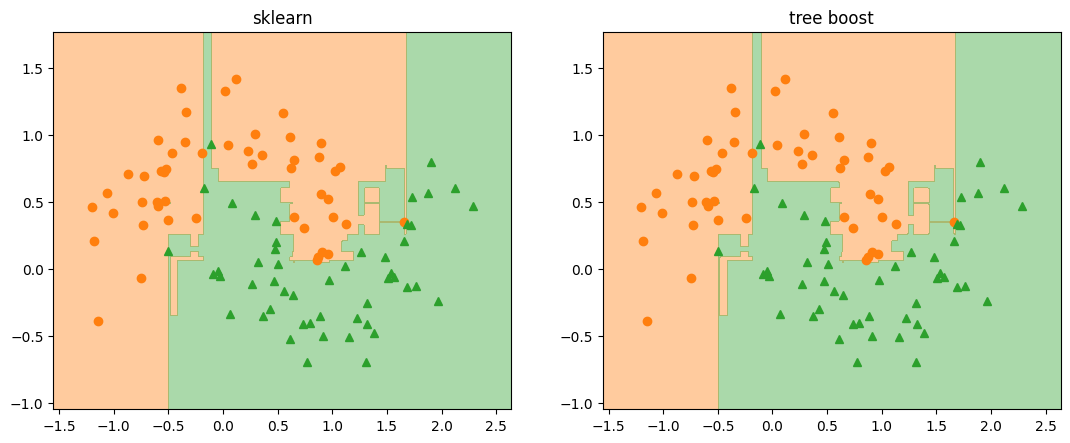

In [ ]:
# 그림으로 확인
X = X_clf2
y = y_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred_tb_x_clf2_tree_dev = predict_tree_boost(X_grid, tb_clf2_tree_dev)

Z = np.zeros(X_grid.shape[0])
Z[pred_tb_x_clf2_tree_dev >= 0.5] = 1.
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, pred_x_clf2_sk, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_title('sklearn')

ax[1].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[1].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[1].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_title('tree boost')

plt.show()

pred_tb_x_clf2_tree_dev = Z.copy()
#
# fig.savefig("clf2_sk_and_tb.png", dpi=image_dpi, bbox_inches='tight')

In [ ]:
np.sum( pred_tb_x_clf2_tree_dev != pred_x_clf2_sk )

0

사이킷런 결과와 완벽하게 일치합니다!

이렇게 사이킷런에서 그래디언트 부스팅을 구현한 방식을 완전히 재현했습니다. 몇가지 다른 예를 테스트해보겠습니다.

#### 추가 예제



##### gaussian_quantiles

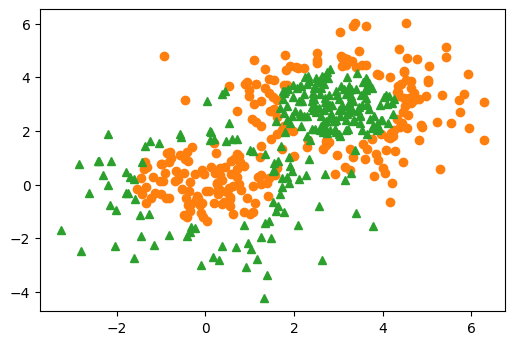

In [ ]:
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=10
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=10
)

X_clf3 = np.concatenate((X1, X2))
y_clf3 = np.concatenate((y1, -y2 + 1))

fig = plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X_clf3[y_clf3==0][:, 0], X_clf3[y_clf3==0][:, 1], 'o', color='C1')
ax.plot(X_clf3[y_clf3==1][:, 0], X_clf3[y_clf3==1][:, 1], '^', color='C2')

plt.show()

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 1.0
tb_clf3_tree_dev = train_tree_boost(X_clf3, y_clf3, h, M=10, 
                                   lr=learning_rate, loss=deviance_loss)

In [ ]:
learning_rate = 1.0
gb_clf3_sk = GradientBoostingClassifier(criterion='squared_error', 
                                        learning_rate=learning_rate, 
                                        n_estimators=10, max_depth=2)
gb_clf3_sk.fit(X_clf3, y_clf3)


GradientBoostingClassifier(criterion='squared_error', learning_rate=1.0,
                           max_depth=2, n_estimators=10)

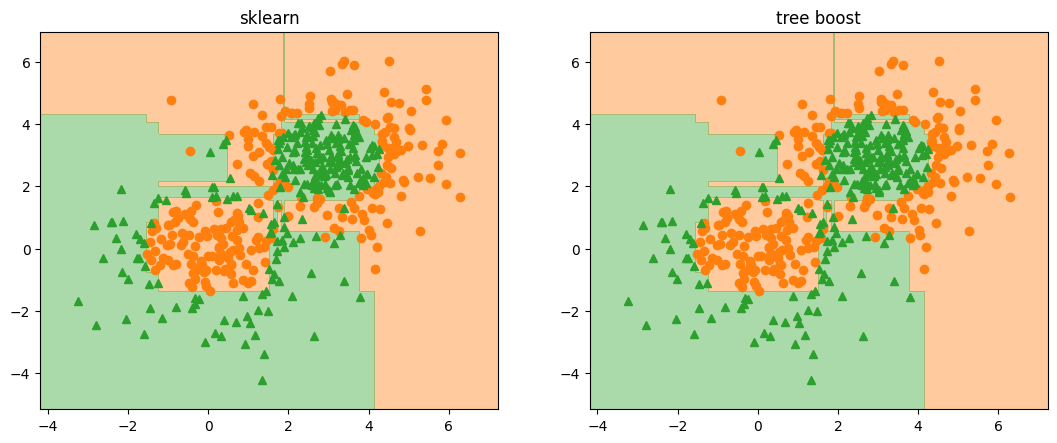

In [ ]:
# 그림으로 확인
X = X_clf3
y = y_clf3

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred = predict_tree_boost(X_grid, tb_clf3_tree_dev)
pred_tb_x_clf3_tree_dev = np.zeros(X_grid.shape[0])
pred_tb_x_clf3_tree_dev[pred >= 0.5] = 1.
pred_tb_x_clf3_tree_dev = pred_tb_x_clf3_tree_dev.reshape(X1.shape)

pred_x_clf3_sk = gb_clf3_sk.predict(X_grid)
pred_x_clf3_sk = pred_x_clf3_sk.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(13,5), nrows=1, ncols=2, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, pred_x_clf3_sk, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].set_title('sklearn')

ax[1].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[1].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[1].contourf(X1, X2, pred_tb_x_clf3_tree_dev, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)
ax[1].set_title('tree boost')

plt.show()



In [ ]:
np.sum( pred_tb_x_clf3_tree_dev != pred_x_clf3_sk )

0

##### Iris dataset

In [ ]:
# 아이리스에 대해서
from sklearn.datasets import load_iris

iris = load_iris()

X_iris = iris['data']
# y_iris = iris['target']
y_iris = (iris["target"] == 2).astype(int)


In [ ]:
# y_iris[130] = 0
# np.log( y_iris.mean() / (1-y_iris.mean()) )

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 1.0
tb_iris = train_tree_boost(X_iris, y_iris, h, M=10, 
                              lr=learning_rate, loss=deviance_loss)

gb_iris_sk = GradientBoostingClassifier(criterion='squared_error', 
                                 learning_rate=learning_rate, 
                                  n_estimators=10, max_depth=2)
gb_iris_sk.fit(X_iris, y_iris)

GradientBoostingClassifier(criterion='squared_error', learning_rate=1.0,
                           max_depth=2, n_estimators=10)

In [ ]:
pred_tb_iris_proba = predict_tree_boost(X_iris, tb_iris)
pred_iris_sk_proba = gb_iris_sk.predict_proba(X_iris)

In [ ]:
# 소수 6자리에서 반올림해서 비교
np.sum( 
    (
        np.round(pred_tb_iris_proba, 6) != np.round(pred_iris_sk_proba[:,1],6)
    ).astype(int)  
)

0

#### 규제, shrinkage

마지막으로 shrinkage라고 하는 규제 방법에 대해서 이야기하고 글을 마무리 하겠습니다. 앞서 개별 트리 학습기의 리프 노드 출력값을 테일러 시리즈 2차 근사를 통해 다음처럼 직접 구하는 방법을 알아봤습니다.

$$
F_m(x) = F_{m-1}(\mathbf{x}) + \sum_{j=1}^{J_m} \gamma_{jm} \mathbb{1}(\mathbf{x} \in R_{jm}), \qquad \gamma_{jm} = \underset{\gamma}{\text{argmin}} \sum_{\mathbf{x}_i \in R_{jm}} L \left(y_i, F_{m-1}(\mathbf{x}_i)+\gamma \right)
$$

이렇게 구해진 값은 2차 근사 형태로 선탐색까지 마친 결과이므로 더 이상 스탭사이즈를 곱하지 않고 그 값을 바로 $F_{m-1}(\mathbf{x})$에 더하게 됩니다. 이런 이유로 앞선 실험에서 학습률을 1로 두었던 것입니다. (그래디언트에 곱하는 숫자를 1로 두어 아무것도 곱하지 않는것과 같다는 의미)

하지만 최종 구현에서는 $F_{m-1}(\mathbf{x})$에 더해지는 $\gamma_{jm}$의 기여 정도를 조정하기 위해 마치 학습률처럼 1보다 작은 상수를 곱하게 됩니다. 따라서 위 업데이트 룰은 다음처럼 됩니다.

$$
F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \nu \sum_{j=1}^{J_m} \gamma_{jm} \mathbb{1}(\mathbf{x} \in R_{jm}), \qquad 0 < \nu \le 1
$$

이렇게 개별 학습기의 출력값을 적당히 축소시키면 $\nu=1$인 경우 보다 모델의 일반화 성능이 크게 증가함을 확인할 수 있습니다.

In [ ]:
h = DecisionTreeRegressor(random_state=42, max_depth=2)

learning_rate = 0.1
tb_clf2_tree_dev_nu = train_tree_boost(X_clf2, y_clf2, h, M=50, 
                              lr=learning_rate, loss=deviance_loss)


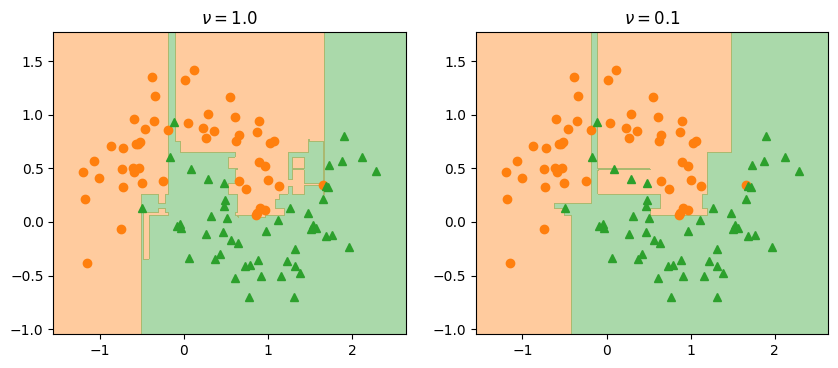

In [ ]:
# 그림으로 확인
X = X_clf2
y = y_clf2

eps = X.std() / 2.
x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
X1, X2 = np.meshgrid(xx, yy)
X_grid = np.c_[X1.ravel(), X2.ravel()]

pred = predict_tree_boost(X_grid, tb_clf2_tree_dev_nu)
Z = np.zeros(X_grid.shape[0])
Z[pred >= 0.5] = 1.
Z = Z.reshape(X1.shape)

fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2, dpi=100)

ax[0].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[0].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[0].contourf(X1, X2, pred_tb_x_clf2_tree_dev, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[0].set_title(r"$\nu=1.0$")
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)

ax[1].plot(X[y==0][:, 0], X[y==0][:, 1], 'o', color='C1')
ax[1].plot(X[y==1][:, 0], X[y==1][:, 1], '^', color='C2')
ax[1].contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
ax[1].set_title(r"$\nu=$"+f"{learning_rate}")
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

plt.show()

# fig.savefig("shrinkage.png", dpi=image_dpi, bbox_inches='tight')

## 마무리

이렇게 좀 길었지만 그래디언트 부스팅에 대해서 자세히 알아봤습니다. 이상의 내용을 잘 이해하고 있으면 최근 가장 각광받고 있는 XGBoost라는 알고리즘을 이해하는 큰 도움이 됩니다. 왜냐하면 XGBoost도 기본적인 논리의 전개는 지금까지 알아본 내용과 모두 같기 때문입니다. 세부적으로 여러 다른 점이 있기는 하지만 핵심적인  차이점은 약한 학습기를 학습시키는 방식으로 목적함수에 규제항을 적용하고 이를 테일러 시리즈 2차 근사하여 뉴턴 메소드를 사용하는 부분입니다.<sup>*)</sup> 그런데 이 방식도 사실 우리 글에서 알아본 TreeBoost에서 리프노드 값을 결정하는 것과 동일한 방식입니다.

제 블로그의 글이 늘 그렇지만 라이브러리를 가져다 사용하는 입장에서는 큰 도움이 되지 않을지 모르겠습니다. 하지만 원리를 파악하고 싶어하는 분들께는 꼭 도움이 되디라 믿으며 글을 마치도록 하겠습니다.

---

*) 물론 가중 분위수 스케치weighted quantile sketch나 하드웨어 특성을 활용해서 효율을 높이는 부분은 너무 세부적이라 이해하기 힘든 내용들이긴 합니다. 하지만 개별 트리를 학습하는데 쓰이는 손실이나 분기점을 찾기 위한 랜덤서치 방식은 이 글을 읽고 나면 충분히 이해할 수 있습니다.


# 참고문헌

1. Jerome H. Friedman, "Greedy function approximation: A gradient boosting machine", Ann. Statist. 29(5) 1189-1232, October 2001.
2. https://en.wikipedia.org/wiki/Gradient_boosting
3. https://scikit-learn.org/stable/modules/ensemble.html#mathematical-formulation
4. StatQuest, Gradient Boost, https://youtu.be/StWY5QWMXCw
5. Hans Sagan, Introduction to the Calculus of Variations, Dover, 1969
